   # Prediction Performance and Interpretability Assessment of Latent Feature Based Methods

   ## Imports and Constants

In [5]:
from __future__ import annotations

from dataclasses import dataclass, field, replace
from datetime import datetime, timedelta, timezone
from functools import lru_cache
from pathlib import Path
from typing import Any, Callable, Sequence
import itertools
import json
import logging

import joblib
import nico2_lib as n2l
from nico2_lib.predictors._scvi._scvi_pred import ScviPredictor
import numpy as np
import polars as pl
import scanpy as sc
import seaborn as sns
from anndata.typing import AnnData
from joblib import Memory
from numpy import number, str_
from numpy.typing import NDArray
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances


DATA_DIR = "./data"
CACHE_DIR = "./cache"
ARTIFACT_SUBDIR = "runs"
DEFAULT_SEED = 0
DEFAULT_N_SAMPLES = 2
DEFAULT_SAMPLE_LENGTH = 20
SCHEMA_VERSION = "2.0.0"
TIMESTAMP_FORMAT = "%Y%m%dT%H%M%SZ"

if not logging.getLogger().handlers:
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    )
logger = logging.getLogger(__name__)


NumericArray = NDArray[number]
StringArray = NDArray[str_]
LoaderFn = Callable[[str], tuple[AnnData, AnnData, str, str]]
PredictorFactory = Callable[..., n2l.pd.PredictorProtocol]
MetricFn = Callable[[NumericArray, NumericArray], float]



   ## Typed Schemas and Config

In [6]:
@dataclass(frozen=True)
class ExperimentConfig:
    data_dir: str = DATA_DIR
    cache_dir: str = CACHE_DIR
    seed: int = DEFAULT_SEED
    n_samples: int = DEFAULT_N_SAMPLES
    sample_length: int = DEFAULT_SAMPLE_LENGTH
    artifact_dir: str = f"{CACHE_DIR}/{ARTIFACT_SUBDIR}"


@dataclass(frozen=True)
class DatasetSpec:
    name: str
    loader: LoaderFn
    metadata: dict[str, Any]


@dataclass(frozen=True)
class PredictorSpec:
    name: str
    factory: PredictorFactory
    kwargs: dict[str, Any]


@dataclass(eq=False)
class EmbeddingBlock:
    block_id: str
    celltype: str | None
    row_indices: NDArray[np.int_]
    values: NumericArray


@dataclass(eq=False)
class SampleResult:
    sample_idx: int
    prediction_scope: str
    train_idx: NDArray[np.int_]
    test_idx: NDArray[np.int_]
    embedding_blocks: list[EmbeddingBlock]
    query_reconstruction: NumericArray
    scores: dict[str, dict[str, float]] = field(default_factory=dict)


@dataclass(eq=False)
class RunSharedData:
    query_counts: NumericArray
    obs_names: NDArray[Any]
    celltypes: StringArray
    train_idxs: NDArray[np.int_]
    test_idxs: NDArray[np.int_]
    feature_names: NDArray[Any]


@dataclass(eq=False)
class RunResult:
    run_metadata: dict[str, Any]
    shared: RunSharedData
    samples: list[SampleResult]


@dataclass(eq=False)
class RunsArtifact:
    schema_version: str
    created_at_utc: str
    config: ExperimentConfig
    runs: list[RunResult]


DEFAULT_CONFIG = ExperimentConfig(
    DATA_DIR,
    CACHE_DIR,
    DEFAULT_SEED,
    DEFAULT_N_SAMPLES,
    DEFAULT_SAMPLE_LENGTH,
    f"{CACHE_DIR}/{ARTIFACT_SUBDIR}",
)



   ## Utility and Loader Helpers

In [7]:
@lru_cache(maxsize=None)
def _get_memory(cache_dir: str) -> Memory:
    return Memory(cache_dir, verbose=0)


def _adata_dense_mut(adata: AnnData) -> None:
    if hasattr(adata.X, "toarray"):
        logger.debug("Densifying AnnData.X with shape=%s", adata.X.shape)
        adata.X = adata.X.toarray()


def _create_spatial_loader(
    query_loader: Callable[[str], AnnData],
    query_ct_key: str,
    reference_loader: Callable[[str], AnnData],
    reference_ct_key: str,
    *,
    memory: Memory,
) -> LoaderFn:
    cached_transfer = memory.cache(n2l.lt.scvi_transfer)

    def loader(data_dir: str) -> tuple[AnnData, AnnData, str, str]:
        logger.info("Loading spatial dataset from %s", data_dir)
        query = query_loader(data_dir)
        reference = reference_loader(data_dir)

        _adata_dense_mut(query)
        _adata_dense_mut(reference)

        query.obs[query_ct_key] = cached_transfer(
            query,
            reference,
            reference_ct_key,
        )
        shared_features = np.intersect1d(query.var_names, reference.var_names)
        return (
            query[:, shared_features],
            reference[:, shared_features],
            query_ct_key,
            reference_ct_key,
        )

    return loader


def _create_pseudospatial_loader(
    loader_func: Callable[[str], AnnData],
    ct_key: str,
    *,
    seed: int,
) -> LoaderFn:
    def split_loader(data_dir: str) -> tuple[AnnData, AnnData, str, str]:
        logger.info("Loading pseudospatial dataset from %s", data_dir)
        rng = np.random.default_rng(seed)
        adata = loader_func(data_dir)
        shuffled_idx = rng.permutation(adata.n_obs)
        split_idx = adata.n_obs // 2

        query = adata[shuffled_idx[:split_idx]].copy()
        reference = adata[shuffled_idx[split_idx:]].copy()

        sc.pp.highly_variable_genes(
            query,
            n_top_genes=500,
            flavor="seurat_v3",
            inplace=True,
        )
        query = query[:, query.var["highly_variable"]].copy()
        return query, reference, ct_key, ct_key

    return split_loader



   ## Registries

In [8]:
def build_dataset_specs(config: ExperimentConfig) -> list[DatasetSpec]:
    memory = _get_memory(config.cache_dir)
    return [
        DatasetSpec(
            name="small_mouse_intestine_spatial",
            loader=_create_spatial_loader(
                n2l.dt.small_mouse_intestine_merfish,
                "cluster",
                n2l.dt.small_mouse_intestine_sc,
                "cluster",
                memory=memory,
            ),
            metadata={"organism": "mouse", "dataset_type": "spatial"},
        ),
        DatasetSpec(
            name="small_mouse_intestine_pseudospatial",
            loader=_create_pseudospatial_loader(
                n2l.dt.small_mouse_intestine_sc,
                "cluster",
                seed=config.seed,
            ),
            metadata={"organism": "mouse", "dataset_type": "pseudospatial"},
        ),
    ]


def build_predictor_specs() -> list[PredictorSpec]:
    return [
        #PredictorSpec(
        #    name="nmf_3",
        #    factory=n2l.pd.NmfPredictor,
        #    kwargs={"n_components": 3},
        #),
        #PredictorSpec(
        #    name="nmf_8",
        #    factory=n2l.pd.NmfPredictor,
        #    kwargs={"n_components": 8},
        #),
        PredictorSpec(
            "scvi_3",
            factory=ScviPredictor,
            kwargs={"n_factors": 3}
        ),
    ]


def aggregate_score(
    score_func: MetricFn,
    agg_func: Callable[[NDArray[np.float64]], float] = np.mean,
    axis: int = 0,
) -> MetricFn:
    def inner_func(x: NumericArray, y: NumericArray) -> float:
        x_m = np.moveaxis(x, axis, 0)
        y_m = np.moveaxis(y, axis, 0)

        scores = np.array([score_func(a, b) for a, b in zip(x_m, y_m)], dtype=float)
        scores = scores[~np.isnan(scores)]
        if scores.size == 0:
            raise ValueError("No finite metric values available to aggregate.")
        return float(agg_func(scores))

    return inner_func


def build_metric_registry() -> list[tuple[str, MetricFn]]:
    return [
        ("pearson", aggregate_score(n2l.mt.pearson_metric)),
        ("mse", aggregate_score(n2l.mt.mse_metric)),
        ("spearman", aggregate_score(n2l.mt.spearman_metric)),
        ("cosine", aggregate_score(n2l.mt.cosine_similarity_metric)),
        ("explaind_var", aggregate_score(n2l.mt.explained_variance_metric)),
        ("explained_var_v2", aggregate_score(n2l.mt.explained_variance_metric_v2)),
    ]


METRIC_REGISTRY = build_metric_registry()



   ## Core Experiment Execution

In [9]:
def _sample_indices(
    total_features: int,
    n_samples: int,
    sample_size: int,
    rng: np.random.Generator,
) -> tuple[NDArray[np.int_], NDArray[np.int_]]:
    if sample_size < 0 or sample_size > total_features:
        raise ValueError(
            f"sample_size must be in [0, total_features], got {sample_size} for {total_features}"
        )

    indices = np.vstack([rng.permutation(total_features) for _ in range(n_samples)])
    train_idx, test_idx = np.split(indices, [sample_size], axis=1)
    return train_idx, test_idx


def _execute_run_uncached(
    dataset: tuple[AnnData, AnnData, str, str],
    predictor: n2l.pd.PredictorProtocol,
    *,
    seed: int,
    n_samples: int,
    sample_length: int,
    run_metadata: dict[str, Any],
) -> RunResult:
    query, reference, query_ct_key, reference_ct_key = dataset

    _adata_dense_mut(query)
    _adata_dense_mut(reference)

    shared_features = np.intersect1d(query.var_names, reference.var_names)
    n_features = shared_features.shape[0]
    rng = np.random.default_rng(seed)
    train_idxs, test_idxs = _sample_indices(n_features, n_samples, sample_length, rng)

    query_celltypes = query.obs[query_ct_key].to_numpy()
    reference_celltypes = reference.obs[reference_ct_key].to_numpy()
    shared_celltypes = np.intersect1d(query_celltypes, reference_celltypes)

    query_shared = query[
        query.obs[query_ct_key].isin(shared_celltypes), shared_features
    ]
    reference_shared = reference[
        reference.obs[reference_ct_key].isin(shared_celltypes), shared_features
    ]

    shared = RunSharedData(
        query_counts=query_shared.X,
        obs_names=query_shared.obs_names.to_numpy(copy=False),
        celltypes=query_shared.obs[query_ct_key].to_numpy(),
        train_idxs=train_idxs,
        test_idxs=test_idxs,
        feature_names=query_shared.var_names.to_numpy(copy=False),
    )
    n_obs = int(query_shared.X.shape[0])

    samples: list[SampleResult] = []

    global_model = predictor.fit(reference_shared.X)
    for sample_idx, (train_idx, test_idx) in enumerate(zip(train_idxs, test_idxs)):
        embedding, prediction = global_model.predict(
            query_shared[:, train_idx].X, train_idx
        )
        embedding_blocks = [
            EmbeddingBlock(
                block_id="global",
                celltype=None,
                row_indices=np.arange(n_obs, dtype=np.int_),
                values=embedding,
            )
        ]
        samples.append(
            SampleResult(
                sample_idx=sample_idx,
                prediction_scope="global",
                train_idx=train_idx,
                test_idx=test_idx,
                embedding_blocks=embedding_blocks,
                query_reconstruction=prediction,
            )
        )

    celltype_models: list[tuple[str, Any, AnnData, NDArray[np.int_]]] = []
    query_shared_celltypes = query_shared.obs[query_ct_key].to_numpy()
    reference_shared_celltypes = reference_shared.obs[reference_ct_key].to_numpy()

    for celltype in shared_celltypes:
        reference_mask = reference_shared_celltypes == celltype
        query_mask = query_shared_celltypes == celltype
        reference_celltype = reference_shared[reference_mask]
        query_celltype = query_shared[query_mask]
        model = predictor.fit(reference_celltype.X)
        query_row_indices = np.flatnonzero(query_mask)
        celltype_models.append((celltype, model, query_celltype, query_row_indices))

    for sample_idx, (train_idx, test_idx) in enumerate(zip(train_idxs, test_idxs)):
        embedding_blocks: list[EmbeddingBlock] = []
        reconstruction_parts = []
        query_row_indices_parts = []

        for celltype, model, query_celltype, query_row_indices in celltype_models:
            embedding, prediction = model.predict(
                query_celltype[:, train_idx].X, train_idx
            )
            embedding_blocks.append(
                EmbeddingBlock(
                    block_id=f"celltype:{celltype}",
                    celltype=str(celltype),
                    row_indices=query_row_indices,
                    values=embedding,
                )
            )
            reconstruction_parts.append(prediction)
            query_row_indices_parts.append(query_row_indices)

        if not embedding_blocks:
            continue

        ordered_idx = np.argsort(np.concatenate(query_row_indices_parts))
        query_reconstruction = np.concatenate(reconstruction_parts, axis=0)[ordered_idx]

        samples.append(
            SampleResult(
                sample_idx=sample_idx,
                prediction_scope="celltype",
                train_idx=train_idx,
                test_idx=test_idx,
                embedding_blocks=embedding_blocks,
                query_reconstruction=query_reconstruction,
            )
        )

    return RunResult(run_metadata=run_metadata, shared=shared, samples=samples)


def execute_run(
    dataset_spec: DatasetSpec,
    predictor_spec: PredictorSpec,
    config: ExperimentConfig,
) -> RunResult:
    dataset = dataset_spec.loader(config.data_dir)
    predictor = predictor_spec.factory(**predictor_spec.kwargs)

    run_metadata = {
        "dataset_name": dataset_spec.name,
        "predictor_name": predictor_spec.name,
        **dataset_spec.metadata,
        **predictor_spec.kwargs,
        "seed": config.seed,
        "n_samples": config.n_samples,
        "sample_length": config.sample_length,
    }

    cached_execute = _get_memory(config.cache_dir).cache(_execute_run_uncached)
    return cached_execute(
        dataset,
        predictor,
        seed=config.seed,
        n_samples=config.n_samples,
        sample_length=config.sample_length,
        run_metadata=run_metadata,
    )



   ## Scoring

In [10]:
def compute_score(
    query: NumericArray,
    query_reconstruction: NumericArray,
    celltypes: StringArray,
    metric_registry: Sequence[tuple[str, MetricFn]],
) -> dict[str, dict[str, float]]:
    if query.shape[0] != query_reconstruction.shape[0]:
        raise ValueError(
            "query and query_reconstruction must have matching n_obs: "
            f"{query.shape[0]} != {query_reconstruction.shape[0]}"
        )
    if query.shape[0] != celltypes.shape[0]:
        raise ValueError(
            f"celltypes length must match n_obs: {celltypes.shape[0]} != {query.shape[0]}"
        )

    unique_celltypes = np.unique(celltypes)
    result: dict[str, dict[str, float]] = {}

    for metric_name, metric_func in metric_registry:
        scores: list[float] = []
        weights: list[int] = []

        for ct in unique_celltypes:
            mask = celltypes == ct
            n = int(mask.sum())
            if n == 0:
                continue
            scores.append(float(metric_func(query[mask], query_reconstruction[mask])))
            weights.append(n)

        if not scores:
            raise ValueError("No celltypes found to score (empty input).")

        result[metric_name] = {
            "weighted": float(np.average(scores, weights=weights)),
            "macro": float(np.mean(scores)),
        }

    return result


def score_run(
    run: RunResult,
    metric_registry: Sequence[tuple[str, MetricFn]],
) -> RunResult:
    scored_samples: list[SampleResult] = []

    for sample in run.samples:
        scores = compute_score(
            run.shared.query_counts[:, sample.test_idx],
            sample.query_reconstruction[:, sample.test_idx],
            run.shared.celltypes,
            metric_registry,
        )
        scored_samples.append(replace(sample, scores=scores))

    return RunResult(
        run_metadata=dict(run.run_metadata),
        shared=run.shared,
        samples=scored_samples,
    )



   ## Persistence (Artifacts)

In [11]:
def _utc_timestamp() -> str:
    return datetime.now(timezone.utc).strftime(TIMESTAMP_FORMAT)


def _parse_utc_timestamp(value: str) -> datetime:
    return datetime.strptime(value, TIMESTAMP_FORMAT).replace(tzinfo=timezone.utc)


def _artifact_path(artifact_dir: Path, timestamp: str) -> Path:
    return artifact_dir / f"runs_{timestamp}.joblib"


def _next_available_timestamp(artifact_dir: Path, base_timestamp: str) -> str:
    dt = _parse_utc_timestamp(base_timestamp)
    while _artifact_path(artifact_dir, dt.strftime(TIMESTAMP_FORMAT)).exists():
        dt += timedelta(seconds=1)
    return dt.strftime(TIMESTAMP_FORMAT)


def _write_json_atomic(path: Path, payload: dict[str, Any]) -> None:
    temp_path = path.with_suffix(f"{path.suffix}.tmp")
    with temp_path.open("w", encoding="utf-8") as fh:
        json.dump(payload, fh, indent=2)
    temp_path.replace(path)


def save_runs_artifact(artifact: RunsArtifact) -> Path:
    artifact_dir = Path(artifact.config.artifact_dir)
    artifact_dir.mkdir(parents=True, exist_ok=True)

    base_timestamp = artifact.created_at_utc or _utc_timestamp()
    timestamp = _next_available_timestamp(artifact_dir, base_timestamp)
    artifact.created_at_utc = timestamp

    target_path = _artifact_path(artifact_dir, timestamp)
    temp_path = target_path.with_suffix(f"{target_path.suffix}.tmp")

    joblib.dump(artifact, temp_path, compress=3)
    temp_path.replace(target_path)

    latest_pointer = {
        "schema_version": artifact.schema_version,
        "latest_artifact": target_path.name,
        "updated_at_utc": _utc_timestamp(),
    }
    _write_json_atomic(artifact_dir / "latest.json", latest_pointer)
    return target_path


def _resolve_latest_artifact_path(artifact_dir: Path) -> Path:
    latest_path = artifact_dir / "latest.json"
    if not latest_path.exists():
        raise FileNotFoundError(
            f"No latest artifact pointer found at {latest_path}. "
            "Run run_pipeline(...) first or pass an explicit artifact path."
        )

    try:
        payload = json.loads(latest_path.read_text(encoding="utf-8"))
        latest_name = payload["latest_artifact"]
    except (json.JSONDecodeError, KeyError) as exc:
        raise RuntimeError(f"Failed to parse artifact pointer: {latest_path}") from exc

    artifact_path = artifact_dir / latest_name
    if not artifact_path.exists():
        raise FileNotFoundError(
            f"latest.json points to missing artifact: {artifact_path}. "
            "Run pipeline again or fix latest.json."
        )
    return artifact_path


def list_runs_artifacts(artifact_dir: Path | None = None) -> list[Path]:
    target_dir = (
        Path(DEFAULT_CONFIG.artifact_dir)
        if artifact_dir is None
        else Path(artifact_dir)
    )
    if not target_dir.exists():
        return []
    return sorted(target_dir.glob("runs_*.joblib"))


def load_runs_artifact(path: Path | None = None) -> RunsArtifact:
    if path is None:
        path = _resolve_latest_artifact_path(Path(DEFAULT_CONFIG.artifact_dir))

    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"Runs artifact not found: {path}")

    try:
        artifact = joblib.load(path)
    except Exception as exc:  # noqa: BLE001
        raise RuntimeError(f"Failed to load runs artifact from {path}") from exc

    if not isinstance(artifact, RunsArtifact):
        raise TypeError(
            f"Artifact at {path} has unexpected type {type(artifact).__name__}; "
            "expected RunsArtifact"
        )
    if artifact.schema_version != SCHEMA_VERSION:
        raise RuntimeError(
            "Unsupported artifact schema version: "
            f"{artifact.schema_version!r}; expected {SCHEMA_VERSION!r}."
        )
    return artifact


def load_pipeline_data(path: Path | None = None) -> RunsArtifact:
    return load_runs_artifact(path=path)



   ## Pipeline Entrypoints

In [12]:
def run_pipeline(config: ExperimentConfig) -> RunsArtifact:
    dataset_specs = build_dataset_specs(config)
    predictor_specs = build_predictor_specs()
    runs: list[RunResult] = []

    total = len(dataset_specs) * len(predictor_specs)
    for dataset_spec, predictor_spec in tqdm(
        itertools.product(dataset_specs, predictor_specs),
        total=total,
        desc="Running experiments",
    ):
        run = execute_run(dataset_spec, predictor_spec, config)
        scored_run = score_run(run, METRIC_REGISTRY)
        runs.append(scored_run)

    artifact = RunsArtifact(
        schema_version=SCHEMA_VERSION,
        created_at_utc=_utc_timestamp(),
        config=config,
        runs=runs,
    )
    artifact_path = save_runs_artifact(artifact)
    logger.info("Saved runs artifact to %s", artifact_path)
    return artifact



   ## DataFrame and Plotting

In [13]:
def artifact_to_score_frame(artifact: RunsArtifact) -> pl.DataFrame:
    df_rows: list[dict[str, Any]] = []

    for run in artifact.runs:
        for sample in run.samples:
            base = {
                "dataset_name": run.run_metadata["dataset_name"],
                "predictor_name": run.run_metadata["predictor_name"],
                "prediction_scope": sample.prediction_scope,
                "sample_idx": sample.sample_idx,
            }
            for aggregation_type in ("weighted", "macro"):
                row = base | {"aggregation_type": aggregation_type}
                row |= {
                    metric_name: score_by_agg[aggregation_type]
                    for metric_name, score_by_agg in sample.scores.items()
                }
                df_rows.append(row)

    return pl.DataFrame(df_rows)


def plot_reconstruction_scores(df: pl.DataFrame) -> None:
    if df.height == 0:
        raise ValueError("Score DataFrame is empty; nothing to plot.")

    id_cols = [
        "dataset_name",
        "predictor_name",
        "prediction_scope",
        "sample_idx",
        "aggregation_type",
    ]
    metric_cols = [c for c in df.columns if c not in id_cols]

    plot_df = df.to_pandas().melt(
        id_vars=id_cols,
        value_vars=metric_cols,
        var_name="metric_name",
        value_name="metric_score",
    )

    for dataset_name in plot_df["dataset_name"].drop_duplicates():
        dataset_plot_df = plot_df[plot_df["dataset_name"] == dataset_name]

        g = sns.catplot(
            data=dataset_plot_df,
            kind="box",
            x="predictor_name",
            y="metric_score",
            hue="prediction_scope",
            row="aggregation_type",
            col="metric_name",
            sharey=False,
            height=3.5,
            aspect=1.25,
            margin_titles=True,
        )

        g.fig.suptitle(f"dataset_name = {dataset_name}", y=1.02)
        for ax in g.axes.flat:
            ax.tick_params(axis="x", rotation=45)
            if ax.get_title().endswith("pearson"):
                ax.set_ylim(0, 1)
        g.tight_layout()


def _zscore_rows(values: NumericArray) -> NumericArray:
    row_means = np.nanmean(values, axis=1, keepdims=True)
    row_stds = np.nanstd(values, axis=1, keepdims=True)
    row_stds = np.where((row_stds == 0.0) | np.isnan(row_stds), 1.0, row_stds)
    return (values - row_means) / row_stds


def _zscore_cols(values: NumericArray) -> NumericArray:
    col_means = np.nanmean(values, axis=0, keepdims=True)
    col_stds = np.nanstd(values, axis=0, keepdims=True)
    col_stds = np.where((col_stds == 0.0) | np.isnan(col_stds), 1.0, col_stds)
    return (values - col_means) / col_stds


def _summary_label(dataset_name: str, predictor_name: str, prediction_scope: str) -> str:
    return f"{dataset_name} | {predictor_name} | {prediction_scope}"


def build_embedding_block_cluster_frame(
    artifact: RunsArtifact,
    *,
    pca_components: int = 25,
    random_state: int = 0,
) -> pl.DataFrame:
    rows: list[dict[str, Any]] = []

    for run_idx, run in enumerate(artifact.runs):
        dataset_name = str(run.run_metadata["dataset_name"])
        predictor_name = str(run.run_metadata["predictor_name"])
        query_counts = run.shared.query_counts

        for sample in run.samples:
            prediction_scope = sample.prediction_scope
            sample_idx = sample.sample_idx

            for block in sample.embedding_blocks:
                block_id = block.block_id
                block_celltype = block.celltype
                row_indices = np.asarray(block.row_indices, dtype=np.int_)
                n_cells_block = int(row_indices.size)

                if n_cells_block < 2:
                    continue

                embedding_values = np.asarray(block.values)
                n_latent = int(embedding_values.shape[1])
                query_counts_block = np.asarray(query_counts[row_indices])

                n_features = int(query_counts_block.shape[1])
                pca_n_components = min(pca_components, n_features, n_cells_block - 1)
                if pca_n_components < 1:
                    continue

                n_clusters = min(n_latent, n_cells_block)
                projected = PCA(n_components=pca_n_components).fit_transform(query_counts_block)
                clusters = KMeans(
                    n_clusters=n_clusters,
                    random_state=random_state,
                    n_init="auto",
                ).fit_predict(projected)

                unique_clusters = np.unique(clusters)
                n_clusters_actual = int(unique_clusters.size)
                for cluster_id in unique_clusters:
                    cluster_mean = embedding_values[clusters == cluster_id].mean(axis=0)
                    for latent_idx, value in enumerate(cluster_mean):
                        rows.append(
                            {
                                "run_idx": run_idx,
                                "dataset_name": dataset_name,
                                "predictor_name": predictor_name,
                                "prediction_scope": prediction_scope,
                                "sample_idx": sample_idx,
                                "block_id": block_id,
                                "block_celltype": block_celltype,
                                "cluster_id": int(cluster_id),
                                "latent_idx": latent_idx,
                                "cluster_mean": float(value),
                                "abs_cluster_mean": float(np.abs(value)),
                                "n_clusters": n_clusters_actual,
                                "n_latent": n_latent,
                                "n_cells_block": n_cells_block,
                            }
                        )

    if not rows:
        raise ValueError(
            "No embedding block clusters were produced. "
            "All blocks were skipped due to dimension or clustering constraints."
        )

    return pl.DataFrame(rows)


def compute_embedding_block_metrics(cluster_frame: pl.DataFrame) -> pl.DataFrame:
    key_cols = [
        "run_idx",
        "dataset_name",
        "predictor_name",
        "prediction_scope",
        "sample_idx",
        "block_id",
        "block_celltype",
        "n_clusters",
        "n_latent",
        "n_cells_block",
    ]
    eps = 1e-12
    metrics_rows: list[dict[str, Any]] = []

    cluster_pdf = cluster_frame.to_pandas()
    grouped = cluster_pdf.groupby(key_cols, sort=True, dropna=False)

    for key_values, block_df in grouped:
        key_data = dict(zip(key_cols, key_values))
        matrix = (
            block_df.pivot(index="cluster_id", columns="latent_idx", values="cluster_mean")
            .sort_index(axis=0)
            .sort_index(axis=1)
            .to_numpy(dtype=float)
        )

        absolute_matrix = np.abs(matrix)
        contribution = absolute_matrix / (absolute_matrix.sum(axis=1, keepdims=True) + eps)
        n_latent = matrix.shape[1]

        if n_latent > 1:
            entropies = -np.sum(contribution * np.log(contribution + eps), axis=1) / np.log(
                n_latent
            )
            normalized_entropy_mean = float(np.mean(entropies))
        else:
            normalized_entropy_mean = 0.0

        top1_share_mean = float(np.mean(np.max(contribution, axis=1)))
        specialization_score = float(1.0 - normalized_entropy_mean)

        if matrix.shape[0] < 2:
            cluster_separation = np.nan
        else:
            distances = cosine_distances(matrix)
            upper = distances[np.triu_indices_from(distances, k=1)]
            cluster_separation = float(np.mean(upper)) if upper.size else np.nan

        metrics_rows.append(
            key_data
            | {
                "normalized_entropy_mean": normalized_entropy_mean,
                "top1_share_mean": top1_share_mean,
                "specialization_score": specialization_score,
                "cluster_separation": cluster_separation,
            }
        )

    return pl.DataFrame(metrics_rows)


def aggregate_embedding_block_metrics(metrics_df: pl.DataFrame) -> pl.DataFrame:
    separation = pl.when(pl.col("cluster_separation").is_nan()).then(None).otherwise(
        pl.col("cluster_separation")
    )
    return metrics_df.group_by(
        ["dataset_name", "predictor_name", "prediction_scope"], maintain_order=True
    ).agg(
        pl.col("specialization_score").mean().alias("specialization_score"),
        pl.col("top1_share_mean").mean().alias("top1_share_mean"),
        separation.mean().alias("cluster_separation"),
        pl.col("n_clusters").mean().alias("n_clusters"),
        pl.col("n_latent").mean().alias("n_latent"),
    ).sort(["dataset_name", "predictor_name", "prediction_scope"])


def plot_embedding_block_summary(metrics_df: pl.DataFrame) -> plt.Figure:
    metric_cols = [
        "specialization_score",
        "top1_share_mean",
        "cluster_separation",
        "n_clusters",
        "n_latent",
    ]

    summary_pdf = metrics_df.sort(
        ["dataset_name", "predictor_name", "prediction_scope"]
    ).to_pandas()
    summary_pdf["summary_key"] = summary_pdf.apply(
        lambda row: _summary_label(
            dataset_name=row["dataset_name"],
            predictor_name=row["predictor_name"],
            prediction_scope=row["prediction_scope"],
        ),
        axis=1,
    )

    summary_values = summary_pdf[metric_cols].to_numpy(dtype=float)
    z_values = _zscore_cols(summary_values)
    mask = np.isnan(z_values)

    fig_height = max(5.0, 0.35 * len(summary_pdf))
    fig, ax = plt.subplots(figsize=(12, fig_height))
    sns.heatmap(
        z_values,
        cmap="vlag",
        center=0,
        mask=mask,
        xticklabels=metric_cols,
        yticklabels=summary_pdf["summary_key"].tolist(),
        cbar_kws={"label": "Column-wise z-score"},
        ax=ax,
    )
    ax.set_title(
        "Aggregated embedding metrics per dataset/predictor/prediction_scope "
        "(across all samples and celltypes)"
    )
    ax.set_xlabel("Metrics")
    ax.set_ylabel("Dataset | Predictor | Prediction scope")
    fig.tight_layout()
    plt.show()
    return fig


def plot_embedding_block_details(
    cluster_frame: pl.DataFrame,
    *,
    blocks_per_page: int = 6,
    n_cols: int = 3,
) -> list[plt.Figure]:
    detail_pdf = cluster_frame.sort(
        ["run_idx", "prediction_scope", "sample_idx", "block_id", "cluster_id", "latent_idx"]
    ).to_pandas()

    group_cols = [
        "run_idx",
        "dataset_name",
        "predictor_name",
        "prediction_scope",
        "sample_idx",
    ]
    figures: list[plt.Figure] = []
    grouped = detail_pdf.groupby(group_cols, sort=True, dropna=False)

    for group_key, group_df in grouped:
        run_idx, dataset_name, predictor_name, prediction_scope, sample_idx = group_key
        block_ids = sorted(group_df["block_id"].drop_duplicates().tolist())

        total_pages = int(np.ceil(len(block_ids) / blocks_per_page))
        for page_idx, start in enumerate(range(0, len(block_ids), blocks_per_page), start=1):
            page_block_ids = block_ids[start : start + blocks_per_page]
            n_panels = len(page_block_ids)
            n_rows = int(np.ceil(n_panels / n_cols))

            fig, axes = plt.subplots(
                n_rows,
                n_cols,
                figsize=(5.0 * n_cols, 3.8 * n_rows),
                squeeze=False,
            )

            for ax in axes.flat:
                ax.axis("off")

            for panel_idx, block_id in enumerate(page_block_ids):
                ax = axes.flat[panel_idx]
                ax.axis("on")
                block_df = group_df[group_df["block_id"] == block_id]
                matrix_df = block_df.pivot_table(
                    index="cluster_id",
                    columns="latent_idx",
                    values="cluster_mean",
                    aggfunc="mean",
                ).sort_index(axis=0).sort_index(axis=1)
                matrix = matrix_df.to_numpy(dtype=float)
                z_matrix = _zscore_rows(matrix)

                xticklabels = [f"latent_{int(latent)}" for latent in matrix_df.columns]
                yticklabels = [f"cluster_{int(cluster)}" for cluster in matrix_df.index]
                sns.heatmap(
                    z_matrix,
                    cmap="vlag",
                    center=0,
                    xticklabels=xticklabels,
                    yticklabels=yticklabels,
                    cbar=False,
                    ax=ax,
                )
                ax.set_title(str(block_id), fontsize=10)
                ax.set_xlabel("Latent features")
                ax.set_ylabel("Clusters")
                ax.tick_params(axis="x", rotation=45)

            fig.suptitle(
                f"dataset={dataset_name} | predictor={predictor_name} | "
                f"scope={prediction_scope} | sample={sample_idx} | run={run_idx} | "
                f"page {page_idx}/{total_pages}",
                y=1.02,
            )
            fig.tight_layout()
            plt.show()
            figures.append(fig)

    return figures


def plot_embedding_block_comparisons(
    artifact: RunsArtifact,
    *,
    pca_components: int = 25,
    random_state: int = 0,
    blocks_per_page: int = 6,
    n_cols: int = 3,
) -> dict[str, Any]:
    cluster_frame = build_embedding_block_cluster_frame(
        artifact,
        pca_components=pca_components,
        random_state=random_state,
    )
    metrics_df = compute_embedding_block_metrics(cluster_frame)
    summary_metrics_df = aggregate_embedding_block_metrics(metrics_df)
    summary_figure = plot_embedding_block_summary(summary_metrics_df)
    detail_figures = plot_embedding_block_details(
        cluster_frame,
        blocks_per_page=blocks_per_page,
        n_cols=n_cols,
    )
    return {
        "cluster_frame": cluster_frame,
        "metrics_df": metrics_df,
        "summary_metrics_df": summary_metrics_df,
        "summary_figure": summary_figure,
        "detail_figures": detail_figures,
    }



   ## Notebook Usage Flow

In [14]:
config = ExperimentConfig()
artifact = run_pipeline(config)

Running experiments:   0%|          | 0/2 [00:00<?, ?it/s]2026-02-12 14:06:13,742 | INFO | __main__ | Loading spatial dataset from ./data
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:630: FutureWarning: Setting element `.X` of view of `AnnData` object will obey copy-on-write semantics in the next minor release. 
  if self._handle_view_X_cow(value):
/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_3972/312492981.py:9: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  adata.X = adata.X.toarray()
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supp

Epoch 200/200: 100%|██████████| 200/200 [00:10<00:00, 20.94it/s, v_num=1, train_loss=135]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:10<00:00, 19.57it/s, v_num=1, train_loss=135]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:10<00:00, 19.48it/s, v_num=1, train_loss=131]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:10<00:00, 19.74it/s, v_num=1, train_loss=131]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:02<00:00, 81.81it/s, v_num=1, train_loss=107]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:02<00:00, 82.18it/s, v_num=1, train_loss=107]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 201.89it/s, v_num=1, train_loss=76.7]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 178.62it/s, v_num=1, train_loss=76.7]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 242.78it/s, v_num=1, train_loss=183]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 237.78it/s, v_num=1, train_loss=183]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 191.48it/s, v_num=1, train_loss=67.9]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 201.12it/s, v_num=1, train_loss=67.9]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 121.19it/s, v_num=1, train_loss=162]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 123.47it/s, v_num=1, train_loss=162]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 95.48it/s, v_num=1, train_loss=41]   

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 105.21it/s, v_num=1, train_loss=41]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 204.85it/s, v_num=1, train_loss=135]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 200.59it/s, v_num=1, train_loss=135]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 203.91it/s, v_num=1, train_loss=131]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 189.79it/s, v_num=1, train_loss=131]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 169.82it/s, v_num=1, train_loss=352]  

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 153.54it/s, v_num=1, train_loss=352]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 215.58it/s, v_num=1, train_loss=124]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 204.15it/s, v_num=1, train_loss=124]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 112.31it/s, v_num=1, train_loss=54.7]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 108.30it/s, v_num=1, train_loss=54.7]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:02<00:00, 87.37it/s, v_num=1, train_loss=135]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:02<00:00, 79.84it/s, v_num=1, train_loss=135]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 208.14it/s, v_num=1, train_loss=108]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 182.92it/s, v_num=1, train_loss=108]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 209.63it/s, v_num=1, train_loss=75.6]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 208.23it/s, v_num=1, train_loss=75.6]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 195.30it/s, v_num=1, train_loss=146]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 192.01it/s, v_num=1, train_loss=146]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 217.25it/s, v_num=1, train_loss=138]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 215.40it/s, v_num=1, train_loss=138]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 231.72it/s, v_num=1, train_loss=137]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 223.81it/s, v_num=1, train_loss=137]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 197.44it/s, v_num=1, train_loss=193]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 190.62it/s, v_num=1, train_loss=193]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 231.00it/s, v_num=1, train_loss=125]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 236.26it/s, v_num=1, train_loss=125]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:02<00:00, 80.78it/s, v_num=1, train_loss=105]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:02<00:00, 86.43it/s, v_num=1, train_loss=105]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 225.06it/s, v_num=1, train_loss=66.5]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 215.34it/s, v_num=1, train_loss=66.5]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 249.68it/s, v_num=1, train_loss=165]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 238.92it/s, v_num=1, train_loss=165]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 210.29it/s, v_num=1, train_loss=64.2]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 206.52it/s, v_num=1, train_loss=64.2]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 118.22it/s, v_num=1, train_loss=143]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 117.44it/s, v_num=1, train_loss=143]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 80.16it/s, v_num=1, train_loss=41.2] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 106.03it/s, v_num=1, train_loss=41.2]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 177.62it/s, v_num=1, train_loss=131]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 138.00it/s, v_num=1, train_loss=131]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 205.16it/s, v_num=1, train_loss=172]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 201.32it/s, v_num=1, train_loss=172]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 139.65it/s, v_num=1, train_loss=371]  

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 138.86it/s, v_num=1, train_loss=371]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 185.48it/s, v_num=1, train_loss=125]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 165.00it/s, v_num=1, train_loss=125]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 111.48it/s, v_num=1, train_loss=54.7]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 115.53it/s, v_num=1, train_loss=54.7]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:02<00:00, 87.60it/s, v_num=1, train_loss=135]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:02<00:00, 82.27it/s, v_num=1, train_loss=135]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 209.63it/s, v_num=1, train_loss=99.8]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 205.05it/s, v_num=1, train_loss=99.8]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 220.26it/s, v_num=1, train_loss=75.2]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 211.58it/s, v_num=1, train_loss=75.2]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 226.77it/s, v_num=1, train_loss=159]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 224.94it/s, v_num=1, train_loss=159]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 177.50it/s, v_num=1, train_loss=174]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 173.94it/s, v_num=1, train_loss=174]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 192.45it/s, v_num=1, train_loss=159]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 203.96it/s, v_num=1, train_loss=159]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 183.70it/s, v_num=1, train_loss=214]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 185.25it/s, v_num=1, train_loss=214]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 223.73it/s, v_num=1, train_loss=113]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 229.30it/s, v_num=1, train_loss=113]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/nico2_lib/metrics/_functions.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return pearsonr(x_arr, y_arr).statistic
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/nico2_lib/metrics/_functions.py:51: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(x_arr, y_arr).statistic
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/nico2_lib/metrics/_functions.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return pearsonr(x_arr, y_arr).statistic
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/nico2_lib/metrics/_functions.py:51: ConstantInputWa

Epoch 200/200: 100%|██████████| 200/200 [00:07<00:00, 28.64it/s, v_num=1, train_loss=2.13e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:07<00:00, 26.98it/s, v_num=1, train_loss=2.13e+3]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:07<00:00, 28.06it/s, v_num=1, train_loss=1.67e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:07<00:00, 28.33it/s, v_num=1, train_loss=1.67e+3]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:02<00:00, 80.40it/s, v_num=1, train_loss=1.19e+3] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:02<00:00, 89.79it/s, v_num=1, train_loss=1.19e+3]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 193.37it/s, v_num=1, train_loss=273]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 180.62it/s, v_num=1, train_loss=273]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 169.63it/s, v_num=1, train_loss=664]    

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 139.18it/s, v_num=1, train_loss=664]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 223.05it/s, v_num=1, train_loss=504]  

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 217.52it/s, v_num=1, train_loss=504]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 146.40it/s, v_num=1, train_loss=7.31e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 140.25it/s, v_num=1, train_loss=7.31e+3]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 169.66it/s, v_num=1, train_loss=303]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 157.85it/s, v_num=1, train_loss=303]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 199.90it/s, v_num=1, train_loss=1.1e+3] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 188.90it/s, v_num=1, train_loss=1.1e+3]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 209.92it/s, v_num=1, train_loss=606]    

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 197.02it/s, v_num=1, train_loss=606]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 207.00it/s, v_num=1, train_loss=1.49e+4]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 198.04it/s, v_num=1, train_loss=1.49e+4]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 224.20it/s, v_num=1, train_loss=1.01e+4]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 224.04it/s, v_num=1, train_loss=1.01e+4]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 175.62it/s, v_num=1, train_loss=199]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 174.26it/s, v_num=1, train_loss=199]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 105.29it/s, v_num=1, train_loss=555]  

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 102.14it/s, v_num=1, train_loss=555]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 229.23it/s, v_num=1, train_loss=1.21e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 224.58it/s, v_num=1, train_loss=1.21e+3]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 227.19it/s, v_num=1, train_loss=198]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 227.33it/s, v_num=1, train_loss=198]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 243.52it/s, v_num=1, train_loss=2.21e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 240.63it/s, v_num=1, train_loss=2.21e+3]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 222.41it/s, v_num=1, train_loss=963]    

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 220.66it/s, v_num=1, train_loss=963]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 221.05it/s, v_num=1, train_loss=922]    

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 230.07it/s, v_num=1, train_loss=922]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 249.74it/s, v_num=1, train_loss=2.01e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 248.71it/s, v_num=1, train_loss=2.01e+3]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 251.41it/s, v_num=1, train_loss=665]    

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 251.02it/s, v_num=1, train_loss=665]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 118.09it/s, v_num=1, train_loss=1.51e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 118.31it/s, v_num=1, train_loss=1.51e+3]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 233.53it/s, v_num=1, train_loss=300]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 235.99it/s, v_num=1, train_loss=300]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 249.07it/s, v_num=1, train_loss=616]    

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 250.13it/s, v_num=1, train_loss=616]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 265.21it/s, v_num=1, train_loss=408]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 263.67it/s, v_num=1, train_loss=408]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 170.45it/s, v_num=1, train_loss=8.43e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 173.21it/s, v_num=1, train_loss=8.43e+3]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 160.98it/s, v_num=1, train_loss=251]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 165.48it/s, v_num=1, train_loss=251]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 165.26it/s, v_num=1, train_loss=2.46e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 187.93it/s, v_num=1, train_loss=2.46e+3]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 177.77it/s, v_num=1, train_loss=552]    

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 180.48it/s, v_num=1, train_loss=552]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 175.66it/s, v_num=1, train_loss=3.42e+4]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 176.47it/s, v_num=1, train_loss=3.42e+4]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 214.38it/s, v_num=1, train_loss=8.09e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 206.76it/s, v_num=1, train_loss=8.09e+3]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 147.07it/s, v_num=1, train_loss=253]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 153.16it/s, v_num=1, train_loss=253]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:02<00:00, 92.25it/s, v_num=1, train_loss=583]  

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:02<00:00, 89.12it/s, v_num=1, train_loss=583]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 185.79it/s, v_num=1, train_loss=1.12e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 181.36it/s, v_num=1, train_loss=1.12e+3]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 209.28it/s, v_num=1, train_loss=204]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 218.39it/s, v_num=1, train_loss=204]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 209.60it/s, v_num=1, train_loss=1.48e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 204.51it/s, v_num=1, train_loss=1.48e+3]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 197.10it/s, v_num=1, train_loss=766]    

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 194.79it/s, v_num=1, train_loss=766]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 206.11it/s, v_num=1, train_loss=810]    

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 193.15it/s, v_num=1, train_loss=810]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 197.08it/s, v_num=1, train_loss=2.05e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:01<00:00, 196.86it/s, v_num=1, train_loss=2.05e+3]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/Users/egerc/Docu

Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 226.64it/s, v_num=1, train_loss=446]   

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [00:00<00:00, 216.25it/s, v_num=1, train_loss=446]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData
         setup                                                                  


/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/nico2_lib/metrics/_functions.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return pearsonr(x_arr, y_arr).statistic
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/nico2_lib/metrics/_functions.py:51: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(x_arr, y_arr).statistic
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/nico2_lib/metrics/_functions.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return pearsonr(x_arr, y_arr).statistic
/Users/egerc/Documents/Projects/notebook_repository/2026-02-10T09-07-37Z/.venv/lib/python3.13/site-packages/nico2_lib/metrics/_functions.py:51: ConstantInputWa

In [10]:
# or load artifact via load_pipeline_data(path/to/artifact), no path loading the last run
artifact = load_runs_artifact()


## Plotting

The following plot is a sanity check that the predictors perform as expected.

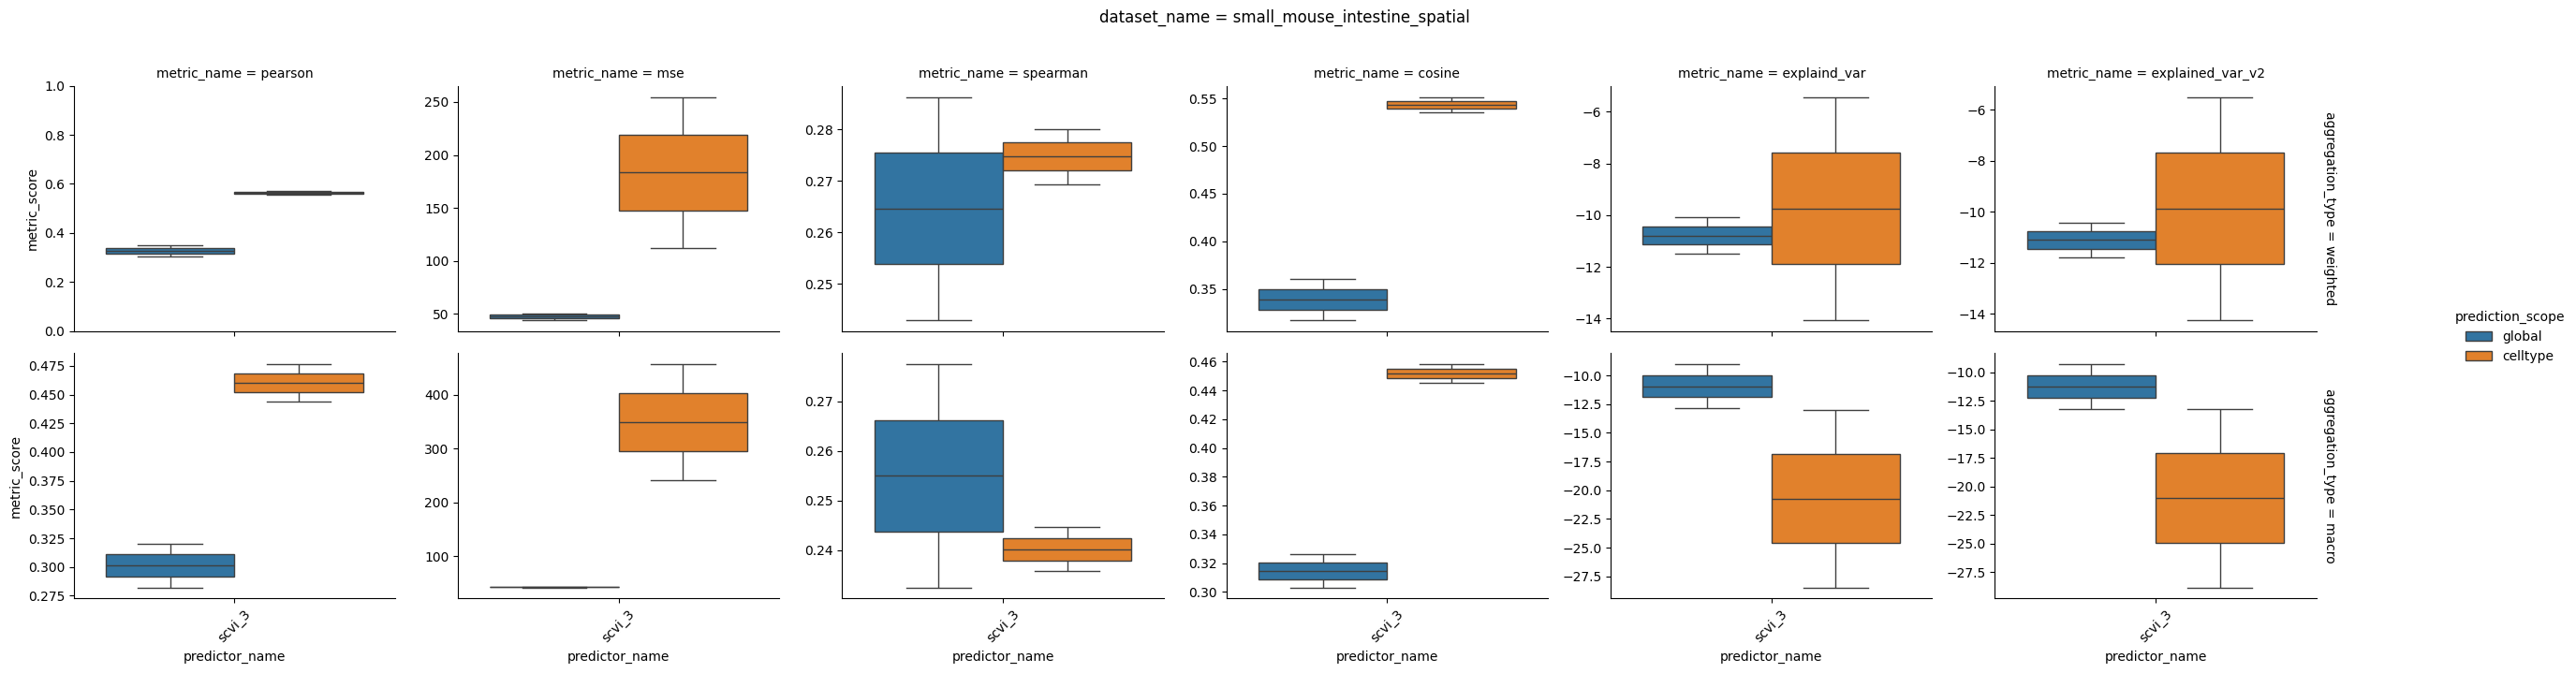

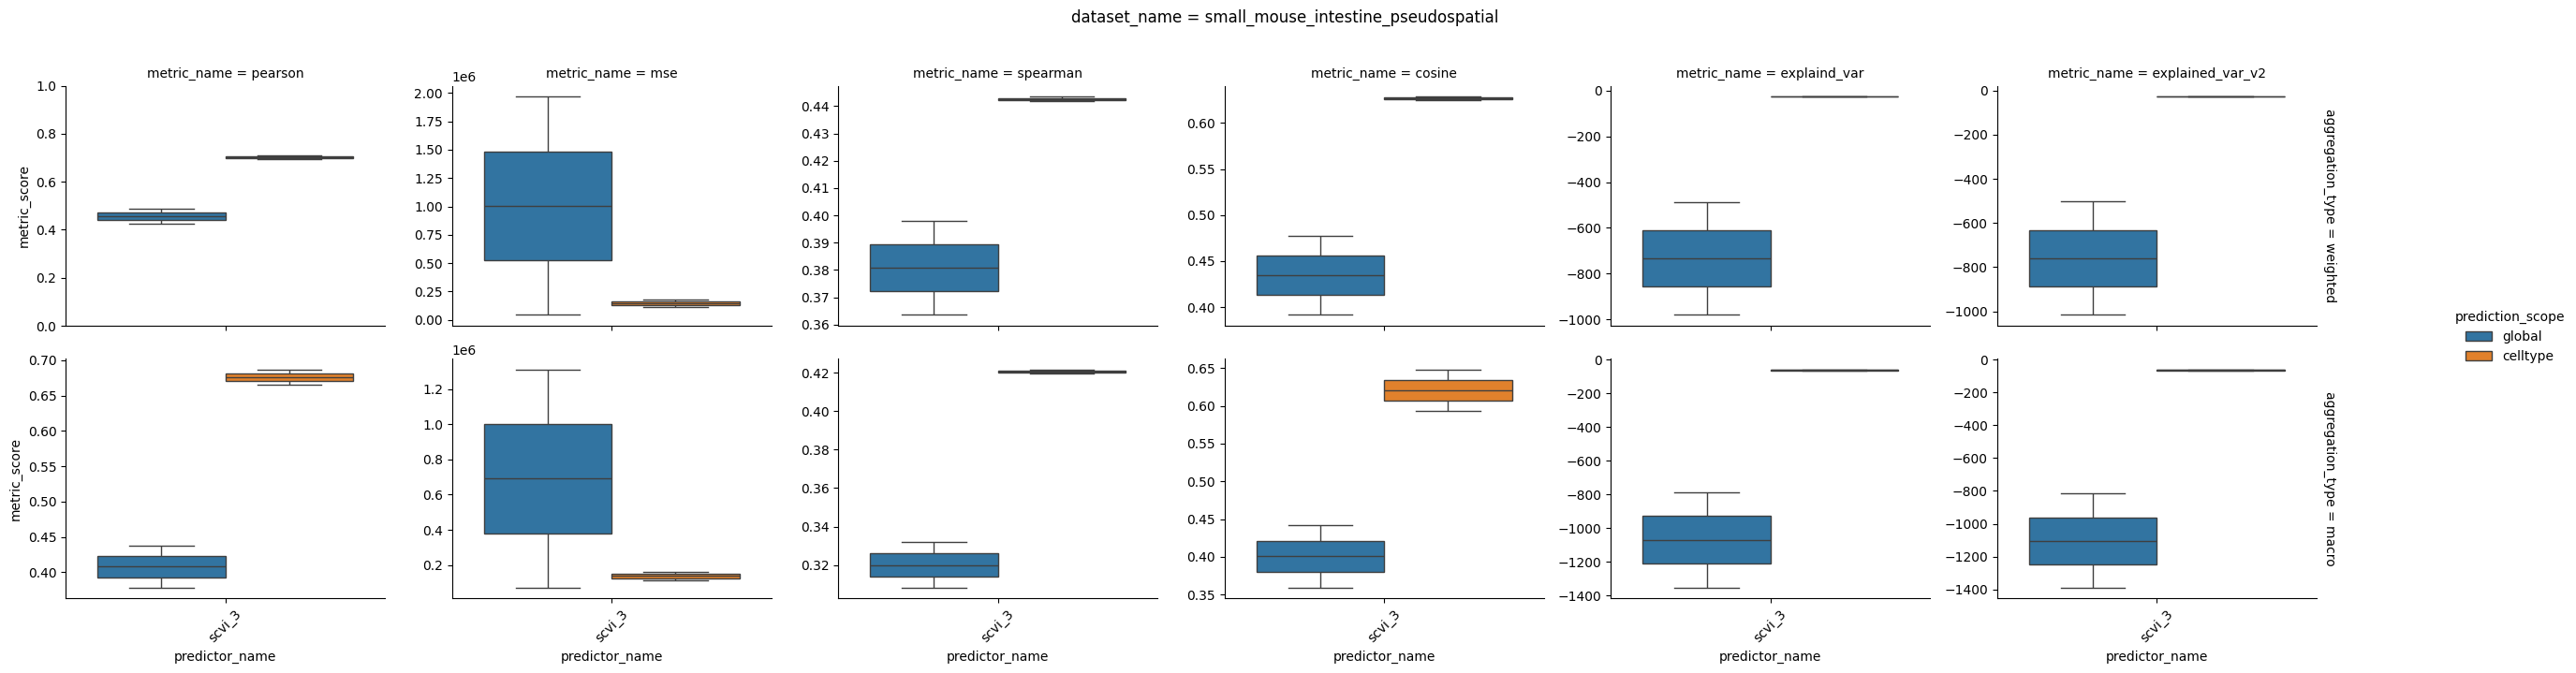

In [15]:
df = artifact_to_score_frame(artifact)

plot_reconstruction_scores(df)


   ### Model Embeddings

   #### Summary score definitions

   - `specialization_score`: Mean of `1 - normalized_entropy` across embedding blocks. The lower the values should mean Factors correspond stronger to clusters instead of being distributed across them

   - `top1_share_mean`: Mean dominant-factor share per cluster, averaged across embedding blocks. Higher means one latent factor tends to dominate each cluster.

   - `cluster_separation`: Mean cosine distance between cluster centroids in latent space, averaged across embedding blocks. Higher means clusters are more distinct.

   - `n_clusters`: Mean number of discovered clusters per embedding block (after `min(n_latent, n_cells_block)`).

   - `n_latent`: Mean latent dimensionality of embedding blocks for that dataset/predictor/scope.

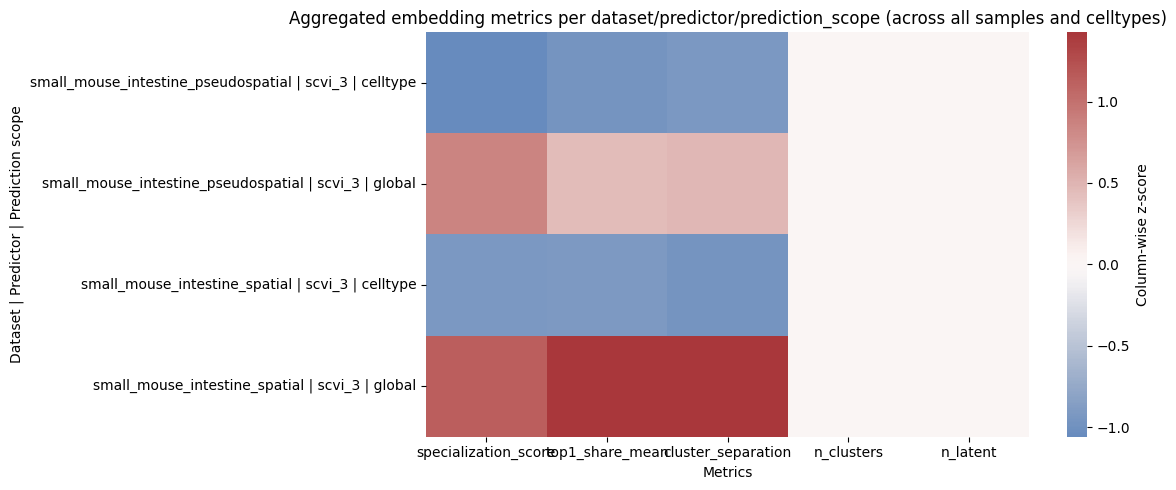

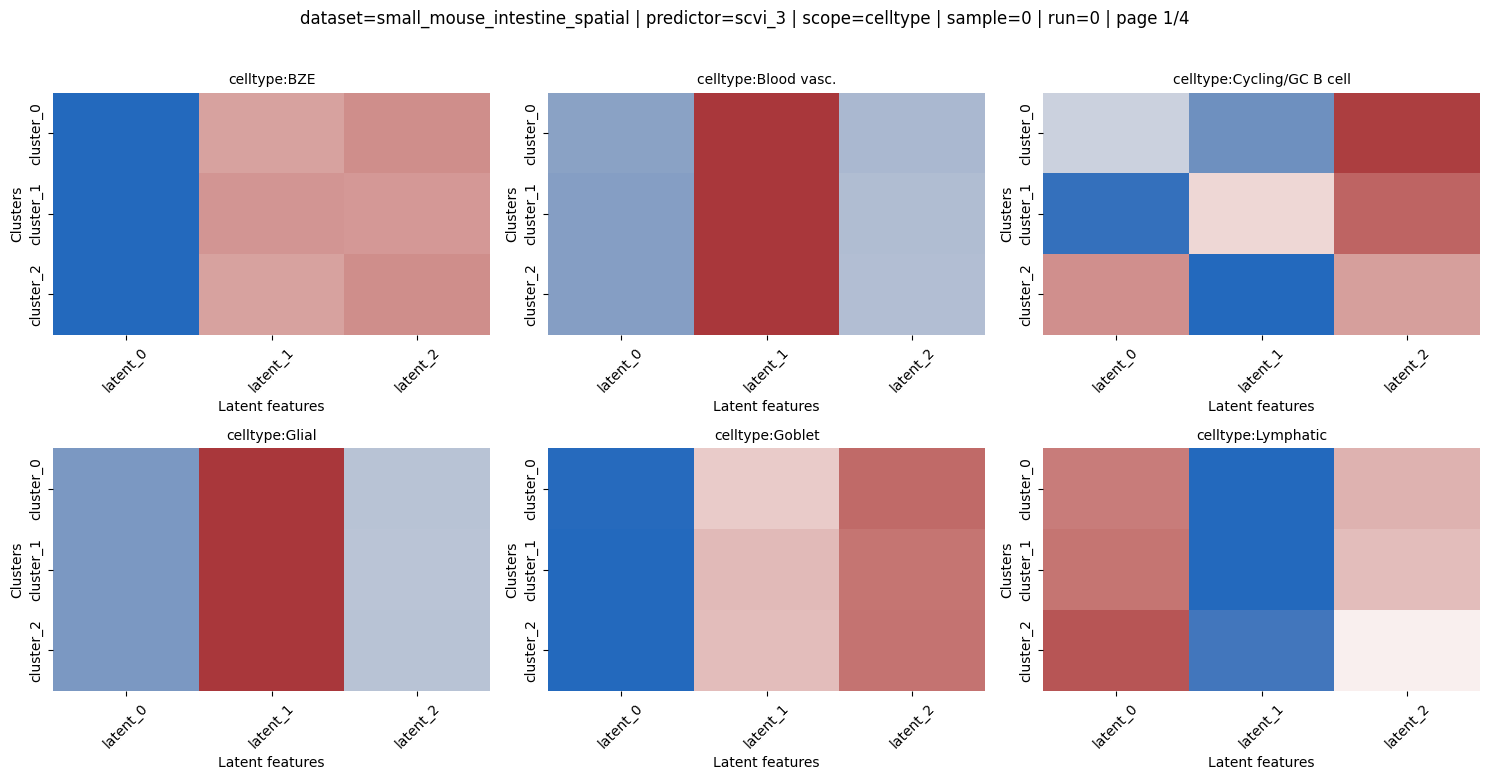

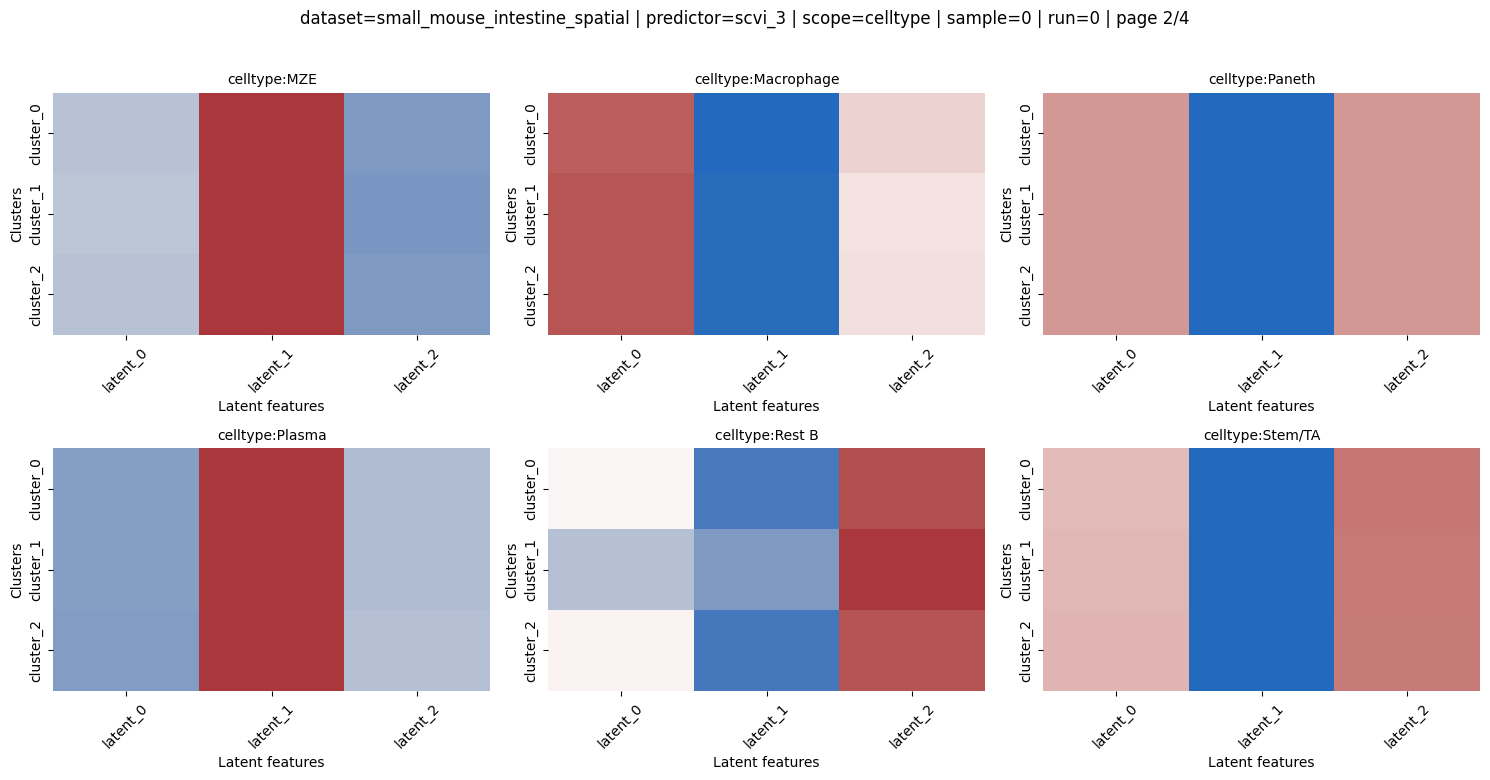

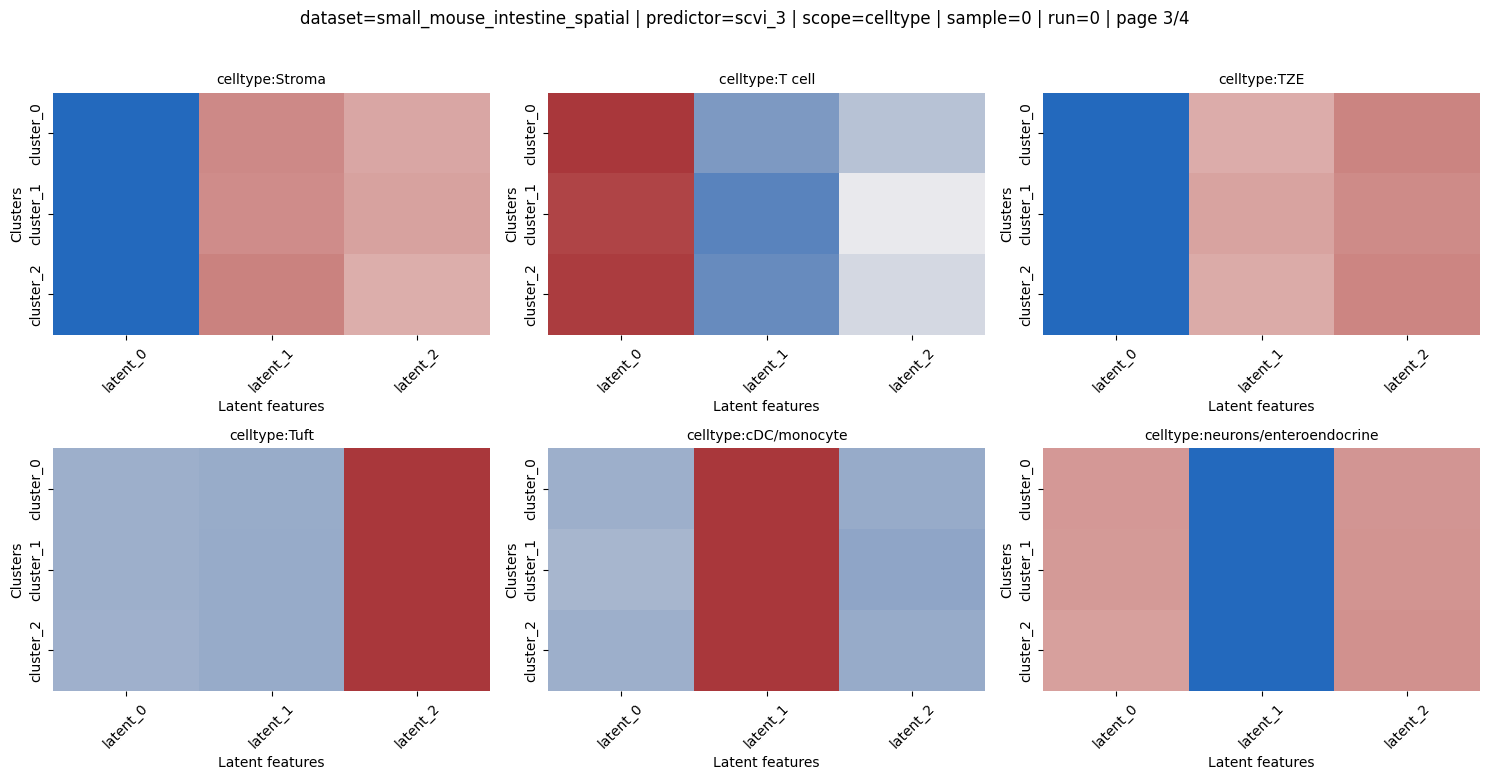

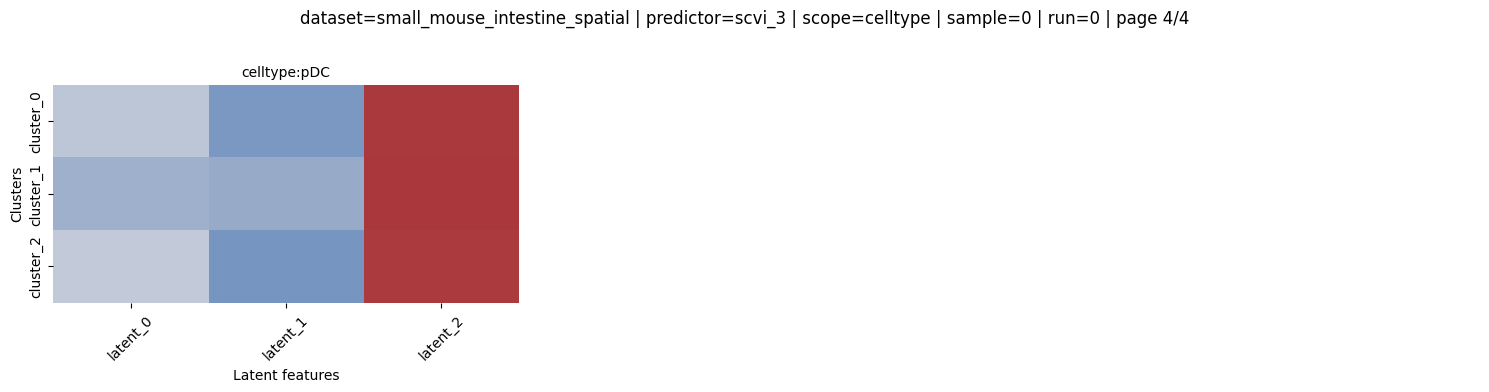

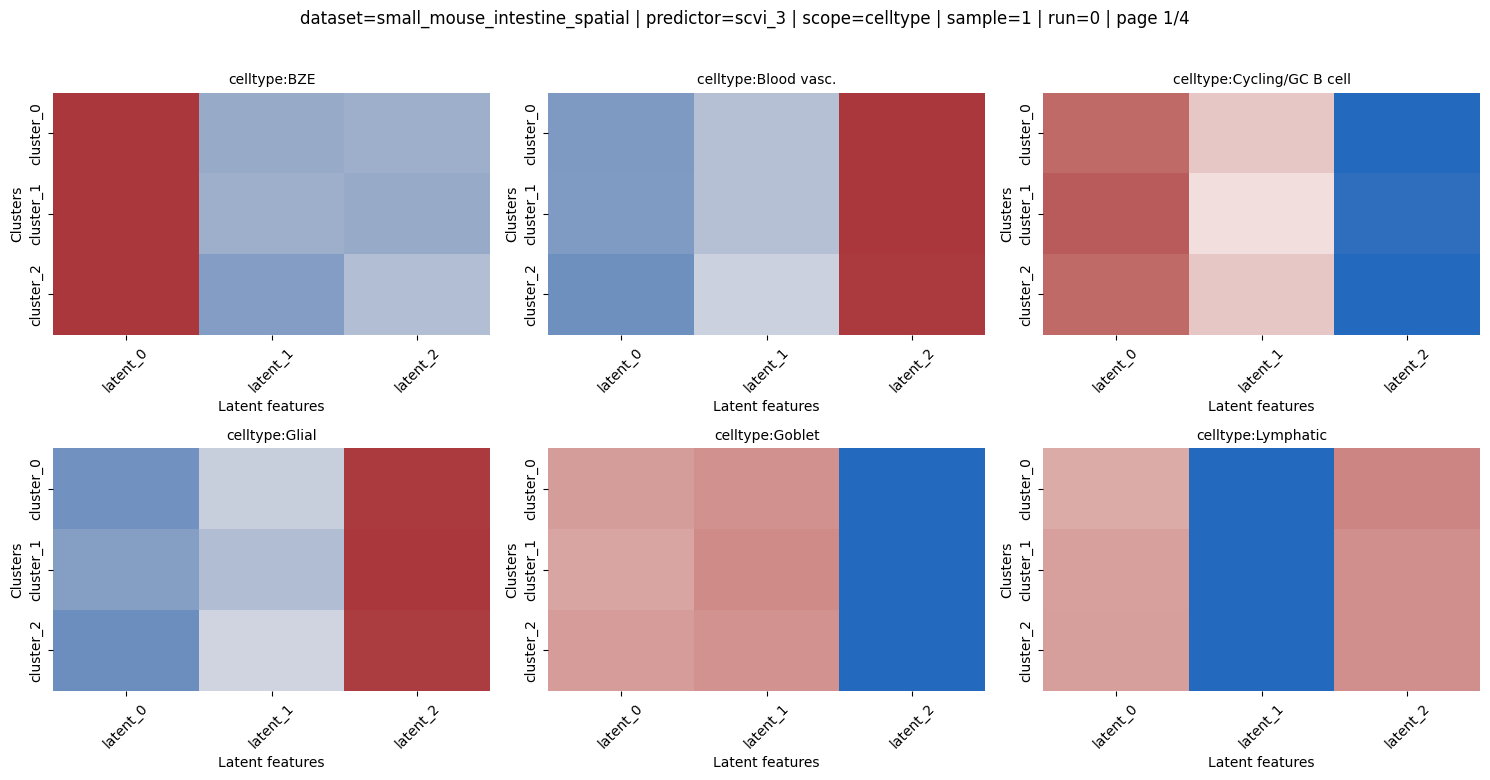

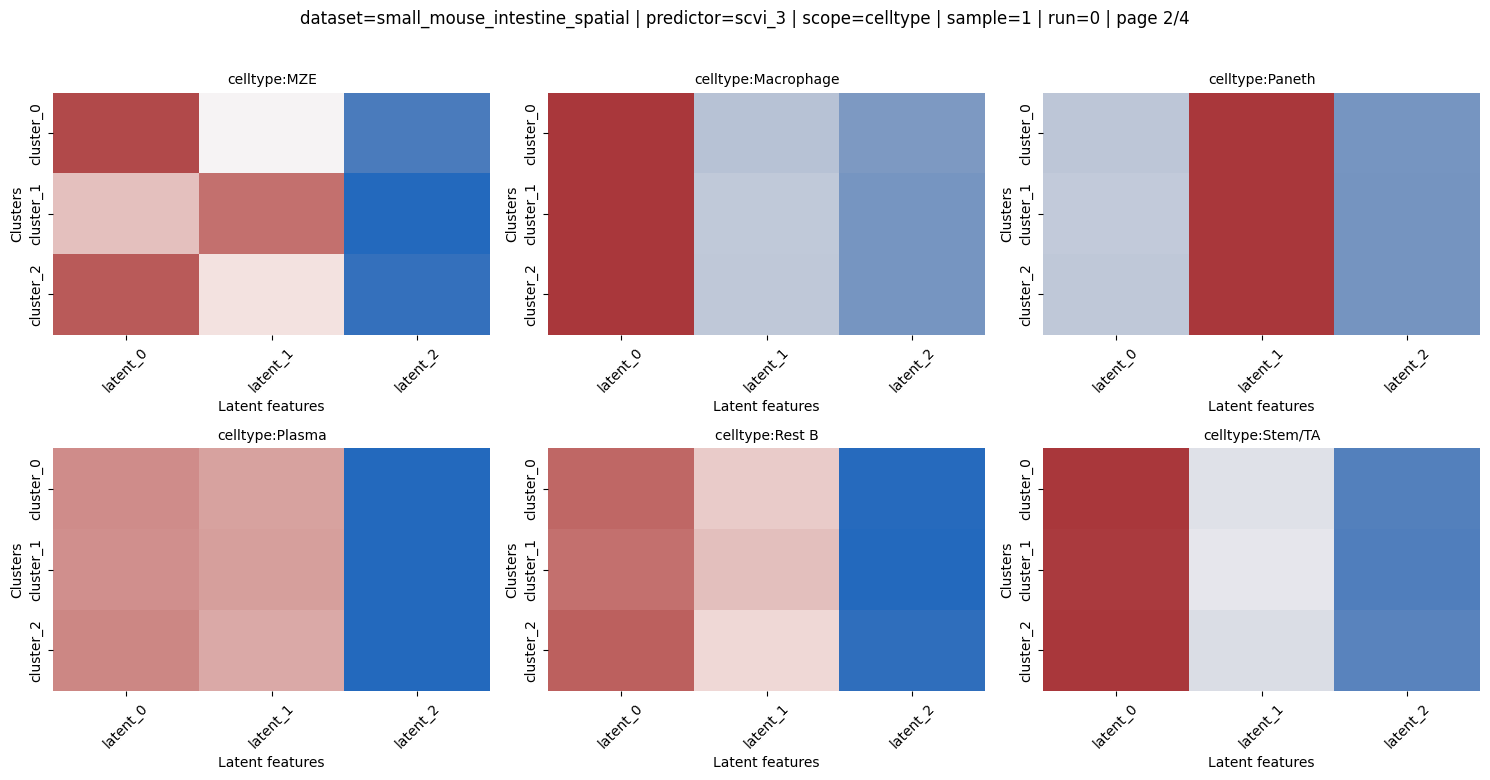

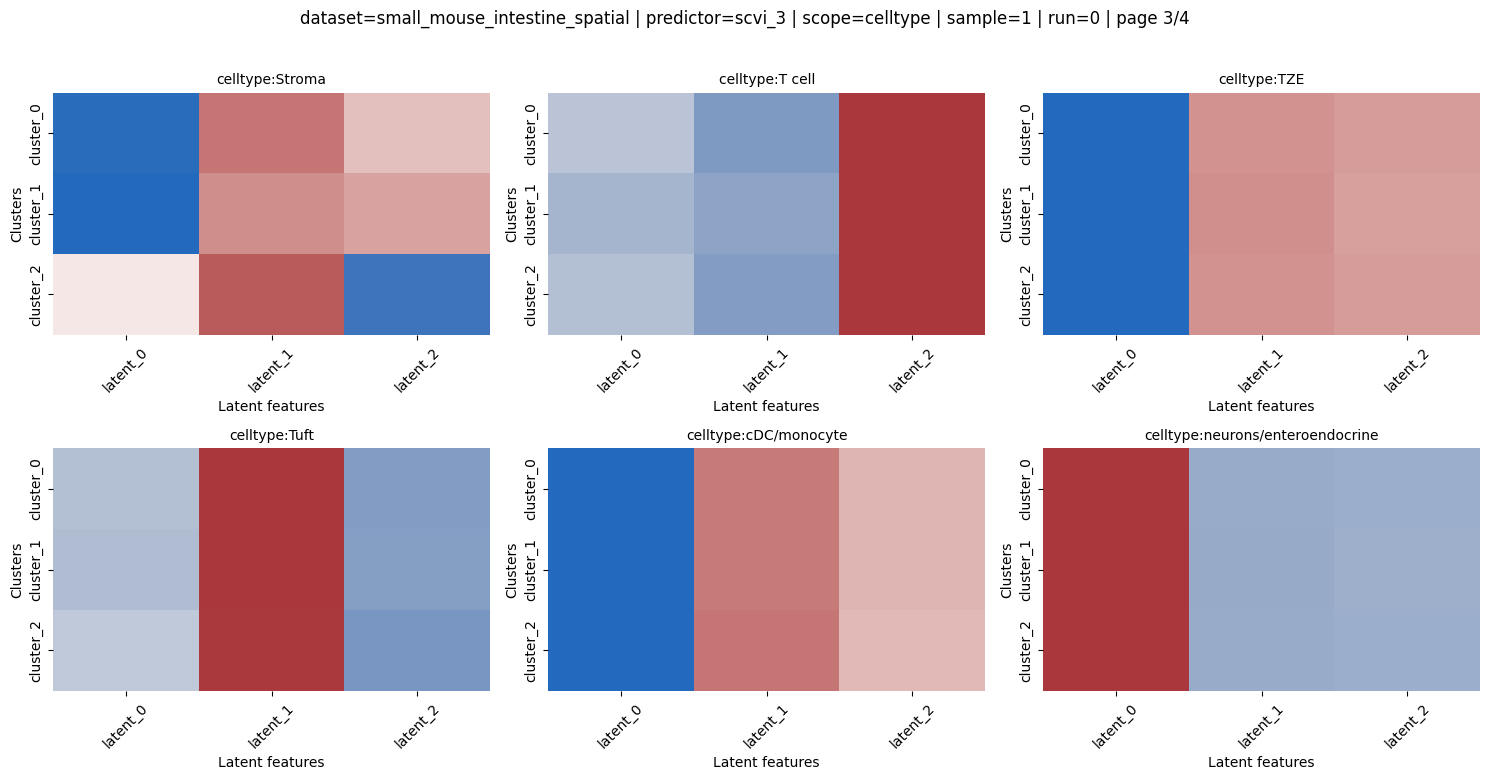

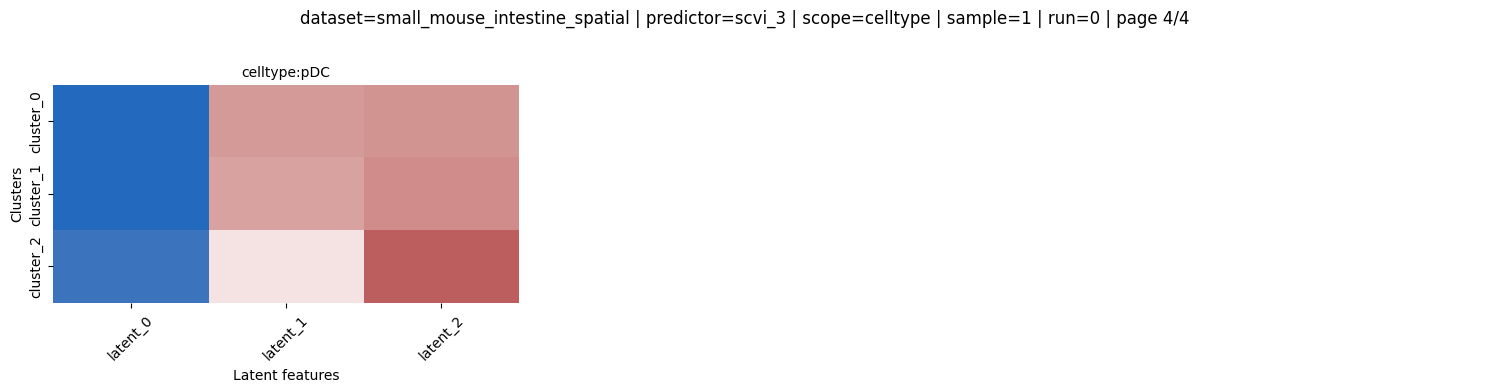

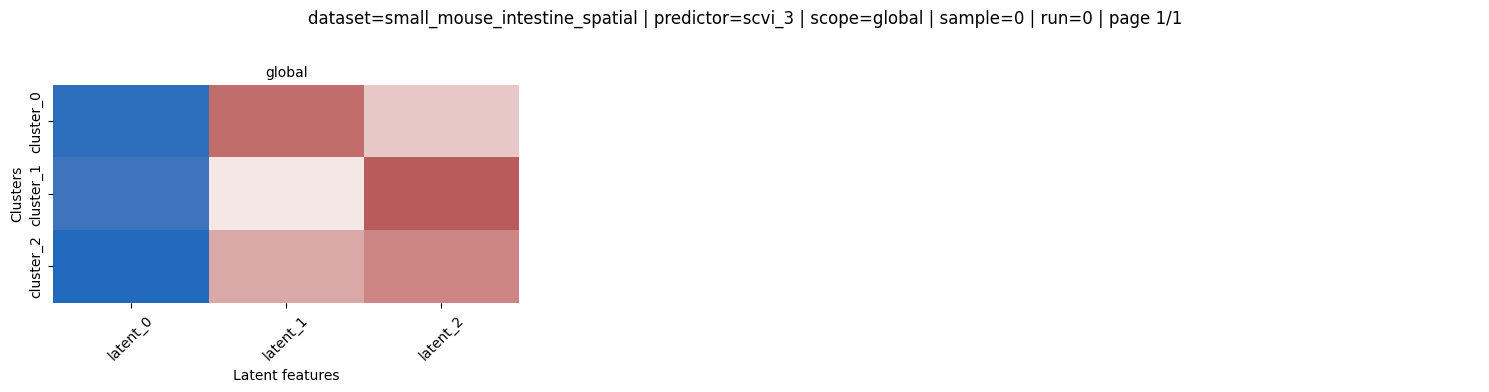

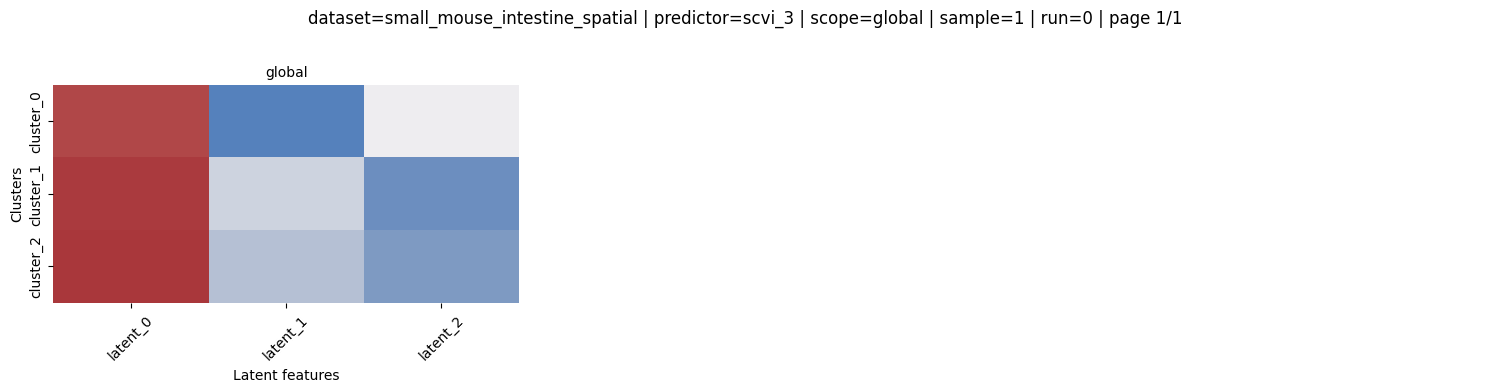

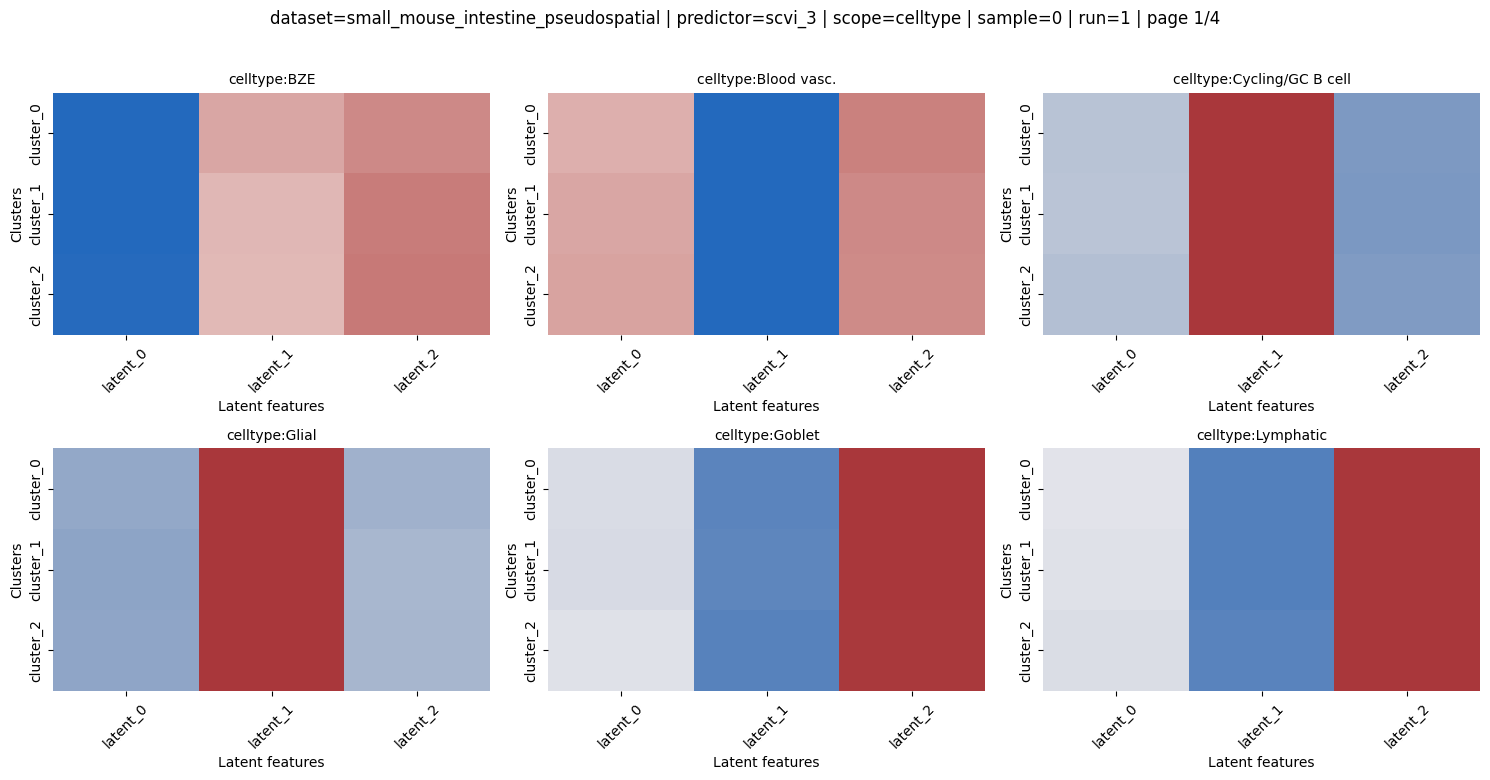

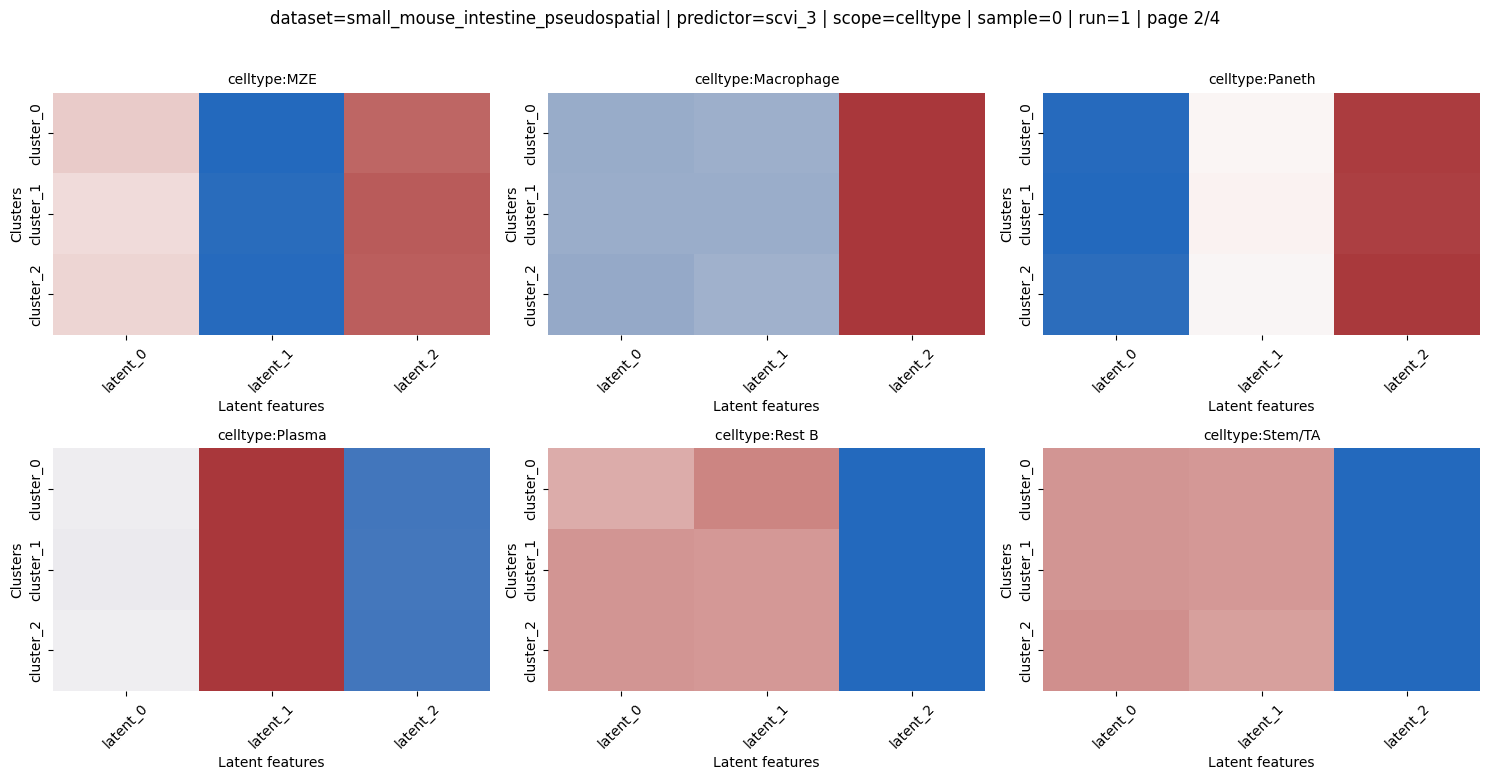

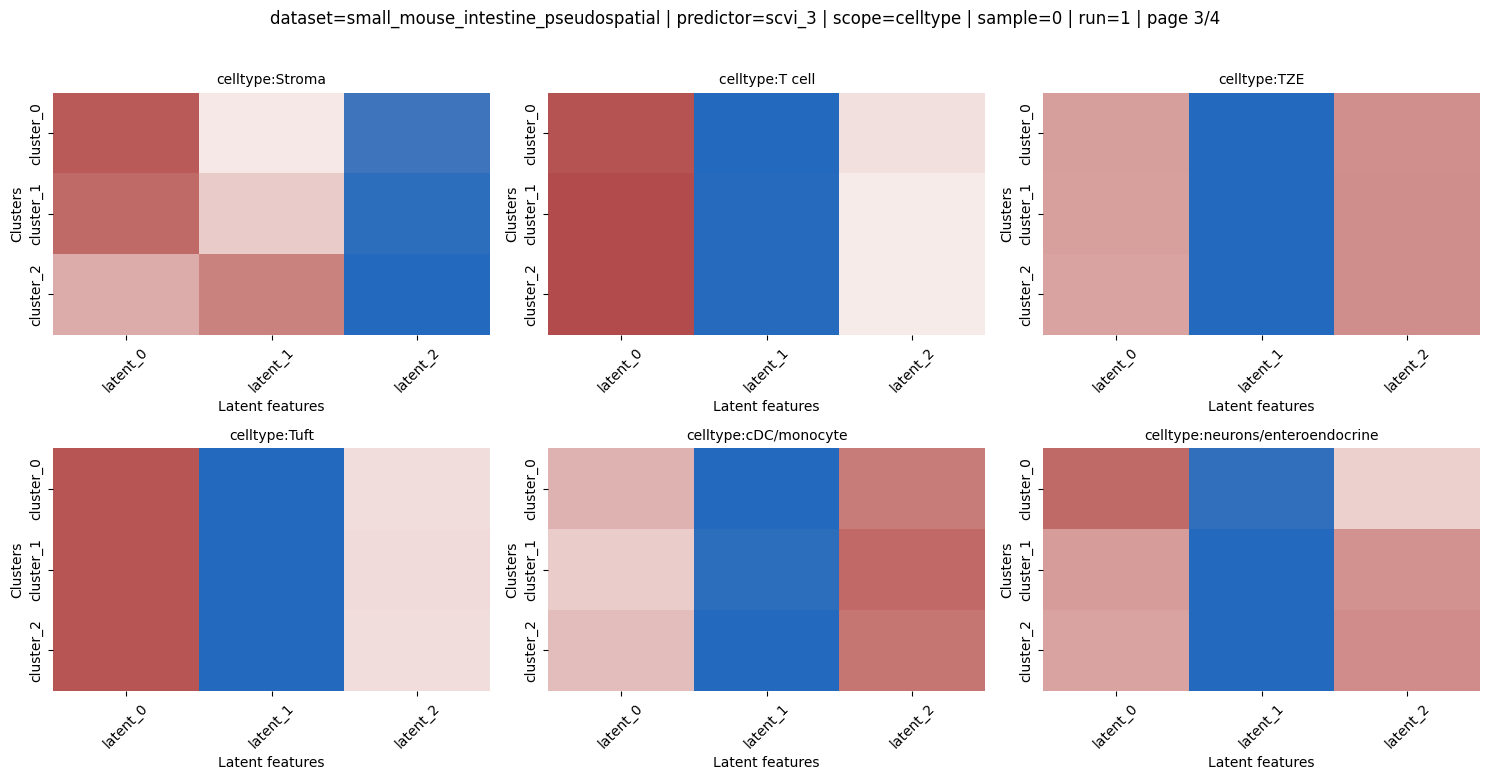

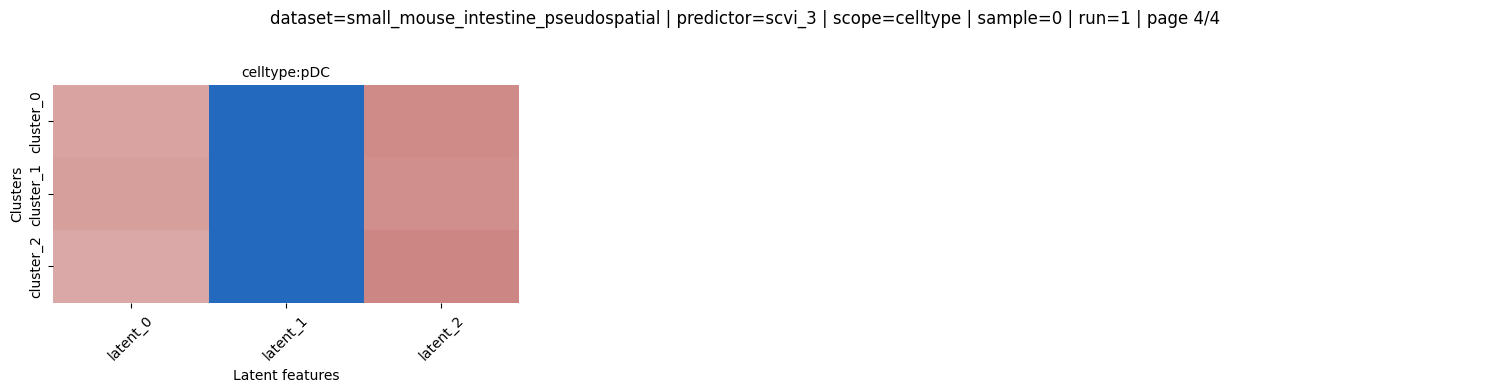

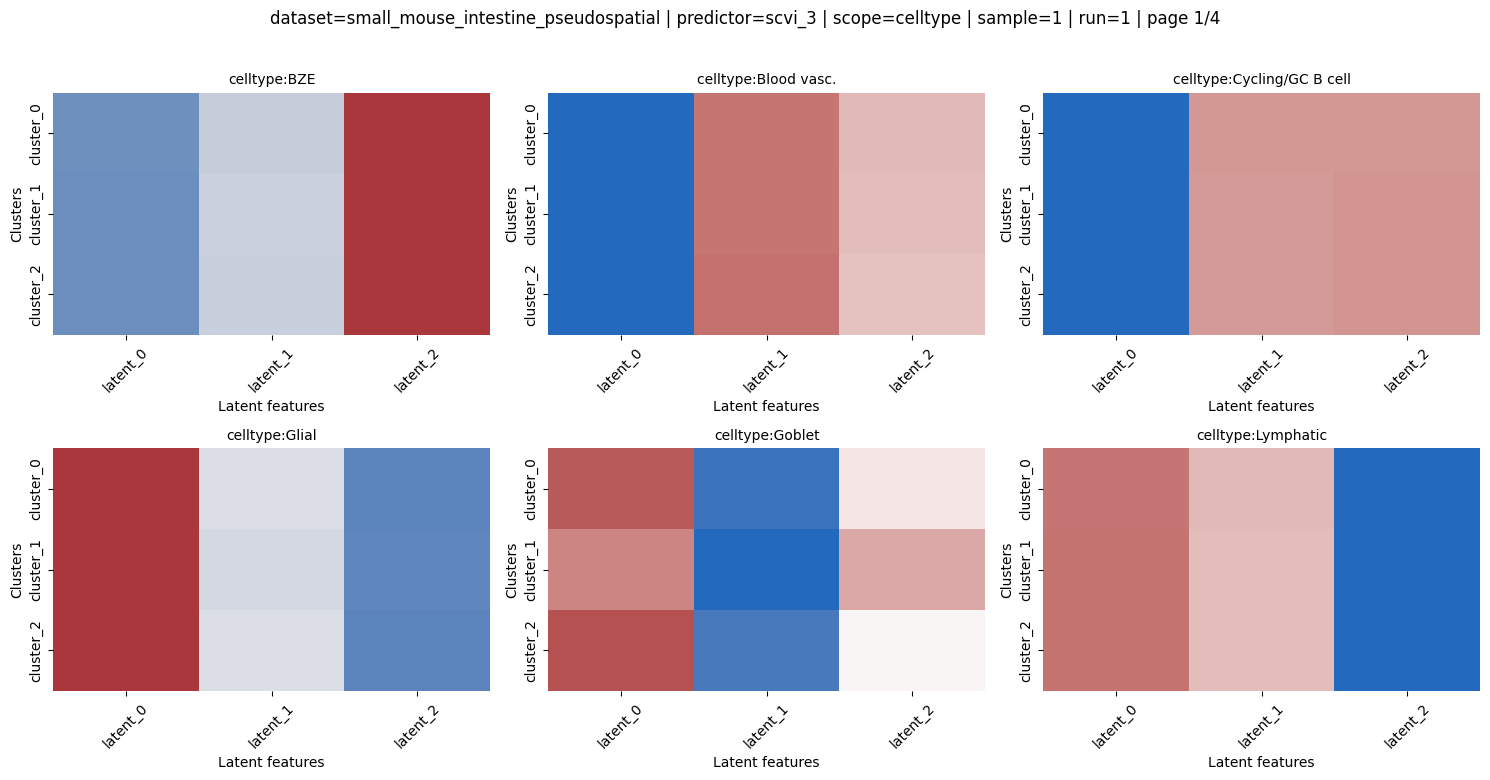

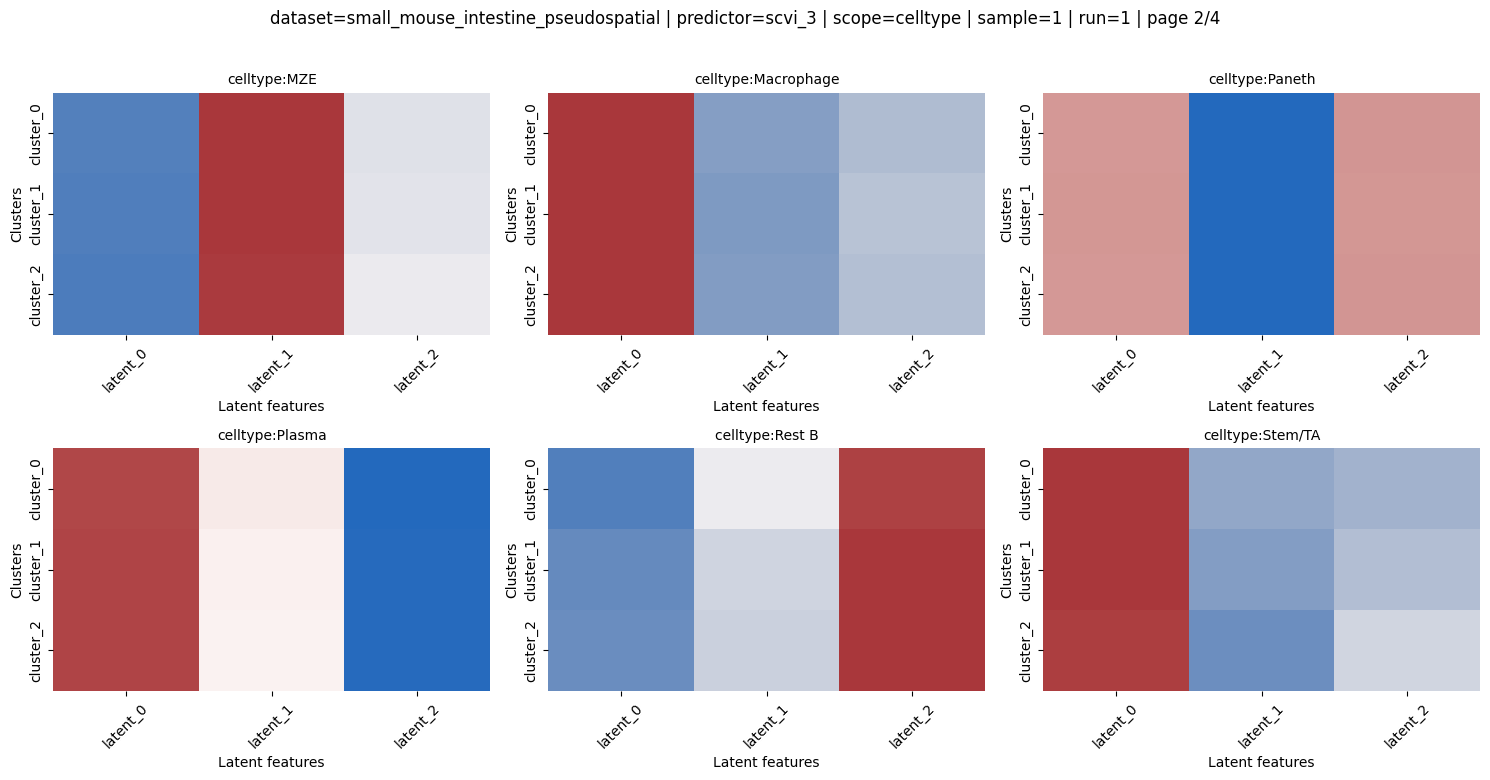

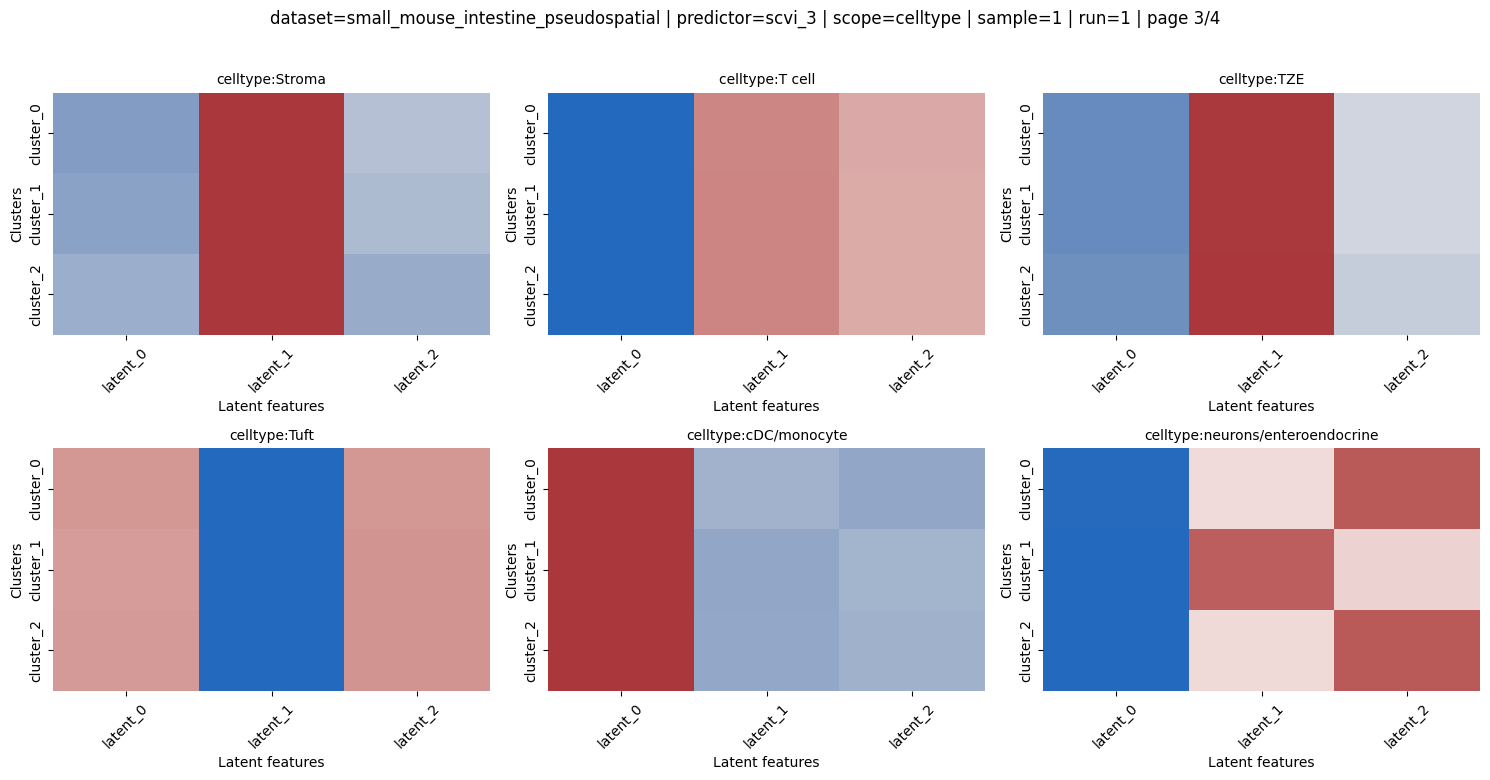

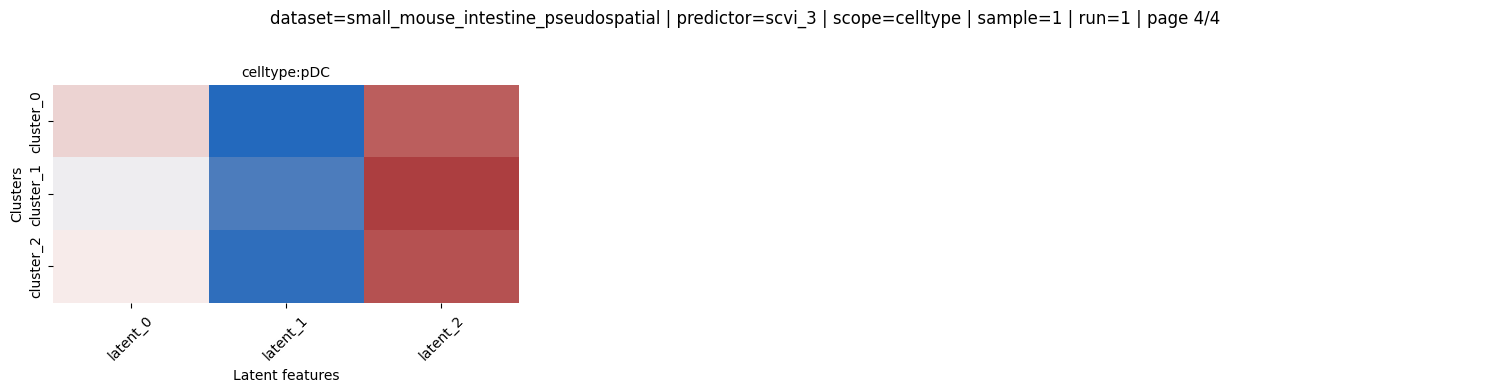

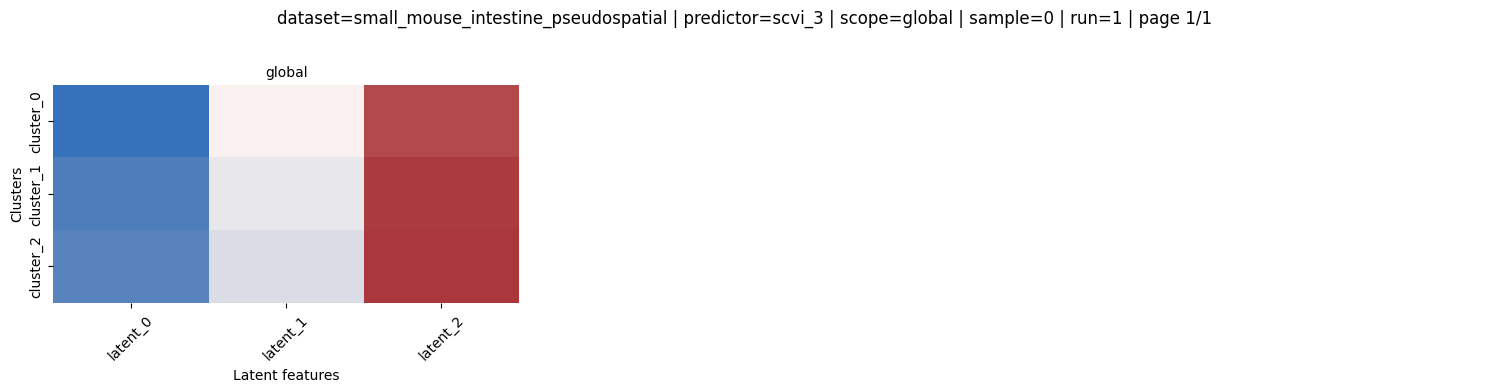

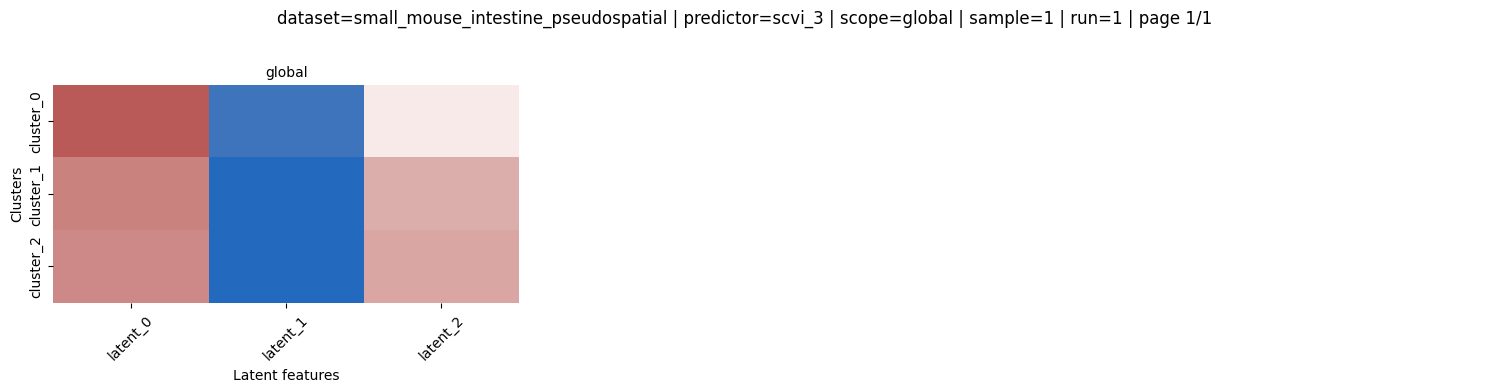

In [16]:
comparison = plot_embedding_block_comparisons(
    artifact,
    pca_components=25,
    random_state=0,
    blocks_per_page=6,
    n_cols=3,
)
